In [1]:
import pandas as pd

# Loading dataset
ind_df = pd.read_csv('../data/indigenous_collection_processed.csv', index_col='id')
print(f'Dataframe columns: \n{ind_df.columns}')

Dataframe columns: 
Index(['url', 'thumbnail', 'creation_date', 'modification_date',
       'numero_do_item', 'tripticos', 'categoria', 'nome_do_item',
       'nome_do_item_dic', 'colecao', 'coletor', 'doador', 'modo_de_aquisicao',
       'data_de_aquisicao', 'ano_de_aquisicao', 'data_de_confeccao', 'autoria',
       'nome_etnico', 'descricao', 'dimensoes', 'funcao', 'materia_prima',
       'tecnica_confeccao', 'descritor_tematico', 'descritor_comum',
       'numero_de_pecas', 'itens_relacionados', 'responsavel_guarda',
       'inst_detentora', 'povo', 'autoidentificacao', 'lingua',
       'estado_de_origem', 'geolocalizacao', 'pais_de_origem', 'exposicao',
       'referencias', 'disponibilidade', 'qualificacao', 'historia_adm',
       'notas_gerais', 'observacao', 'conservacao', 'image_path'],
      dtype='object')


In [2]:
import importlib
from IPython.core.magic import register_cell_magic

# Creating skip cell command
@register_cell_magic
def skip(line, cell):
    return

In [3]:
# Centralizing main imports so we can run the models separately
import random
from tqdm.notebook import tqdm
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt

from image_training_utils import *

# import image_training_utils
# importlib.reload(image_training_utils)
# from image_training_utils import *

# Image Clustering

Clustering experiments with image feature extractors. The idea is to fine-tune some pre-trained transformer models on our dataset and then remove the last layer of the model to cluster on the embedding space projections.

## Dataset Preparation

For fine-tuning the model on our dataset, we are going to try a couple different labels (*povo* and *categoria*) and study how they affect the generated emebdding space.

In [4]:
# Filtering out corrupted images
corrupted_images = []
for index, row in ind_df.loc[ind_df['image_path'].notna()].iterrows():
    try:
        Image.open('../'+row['image_path'])
    except Exception as e:
        corrupted_images.append(row['image_path'])
        ind_df.loc[index, 'image_path'] = pd.NA
print(f'{len(corrupted_images)} corrupted images')

# Creating 'image_path_br' column
ind_df['image_path_br'] = ind_df['image_path'].values
ind_df.loc[ind_df['image_path_br'].notna(), 'image_path_br'] = \
    ind_df.loc[ind_df['image_path_br'].notna(), \
               'image_path'].apply(lambda path: \
                                   f"data/br_images/{path.split('/')[-1].split('.')[0]}.png")

1 corrupted images


## ViT Base Patch-16

### Pre-trained Embedding Space

In [5]:
# Getting the proper device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building dataset for column 'povo' (though no specific column is used on off-the-shelf model)
vit_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
povo_labels, povo_name_to_num, povo_num_to_name = preparing_image_labels(ind_df, 'povo')
povo_dataset = ImageDataset(povo_labels, transform=vit_transform, augment=False)

In [6]:
# Projecting data onto the off-the-shelf pre-trained embedding space from ViT
from transformers import ViTModel

# Loading model
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model.to(device)

# Getting data
povo_dataloader = DataLoader(povo_dataset, batch_size=512, shuffle=True, \
                             num_workers=0, pin_memory=True)

# Computing image embeddings
image_embeddings, vanilla_image_indices = get_embeddings(model, povo_dataloader, device)
image_embeddings = np.concatenate(image_embeddings, axis=0)
vanilla_image_indices = np.concatenate(vanilla_image_indices, axis=0)

# Computing data projection
vanilla_vit_trimap, vanilla_vit_tsne, vanilla_vit_umap = data_projections(image_embeddings)

# Cleaning up memory
clean_mem([model, image_embeddings])

Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [03:16<00:00,  8.54s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Fine-Tuning Embedding Space

In [7]:
# Creating our own ViT classifier (multi-)head for fine-tuning
class ViTClassifier(nn.Module):
    def __init__(self, num_classes1, num_classes2=0, freeze=0):
        super(ViTClassifier, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.classifier1 = nn.Linear(self.vit.config.hidden_size, num_classes1)
        self.multi_head = False
        
        # Multi-head architecture
        if num_classes2 > 0:
            self.classifier2 = nn.Linear(self.vit.config.hidden_size, num_classes2)
            self.multi_head = True
        
        self.freeze_layers(freeze)

    def forward(self, x):
        outputs = self.vit(x)
        
        # Getting embeddings from last_hidden_state of CLS token (maybe pooler_output?)
        embeddings = outputs['last_hidden_state'][:, 0, :]
        # embeddings = outputs['pooler_output']

        logits1 = self.classifier1(embeddings)
        if self.multi_head:
            logits2 = self.classifier2(embeddings)
            return logits1, logits2
        return logits1

    # Freezing early layers so we don't lose generalization and speed up training
    def freeze_layers(self, freeze):
        if freeze <= 0:
            return

        # Accounting for the embedding freeze
        freeze -= 1
        
        for name, param in self.vit.named_parameters():
            if "embeddings" in name:
                param.requires_grad = False
            elif int(name.split('.')[2]) < freeze:
                param.requires_grad = False
            else:
                break

#### *povo* Column

In [8]:
# Studying data distribution to filter out rare classes
povo_categories, categories_keys, categories_freq, \
qs, masks = study_class_distribution(povo_labels)

# Filtering classes so that we retain around 85% of data
povo_filtered_categories = {}
povo_filtered_categories_names = {}
for c in masks[3][0]:
    povo_filtered_categories[categories_keys[c]] = povo_categories[categories_keys[c]]
    
    povo_filtered_categories_names[povo_num_to_name[categories_keys[c]]] = \
    povo_categories[categories_keys[c]]

Quantile X Data Percentage:
Q-10: 1.00, 99.84% of data
Q-25: 4.00, 99.18% of data
Q-50: 19.00, 95.96% of data
Q-75: 65.75, 83.18% of data
Q-90: 158.20, 63.25% of data



In [9]:
# Filtering dataframe for selected categories
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, povo_augmented_dataset, povo_balanced_val_dataset, \
povo_balanced_test_dataset = filter_image_data_distribution(ind_df, \
                                                            povo_filtered_categories_names, \
                                                            vit_transform, \
                                                            threshold_multiplier, \
                                                            'povo')

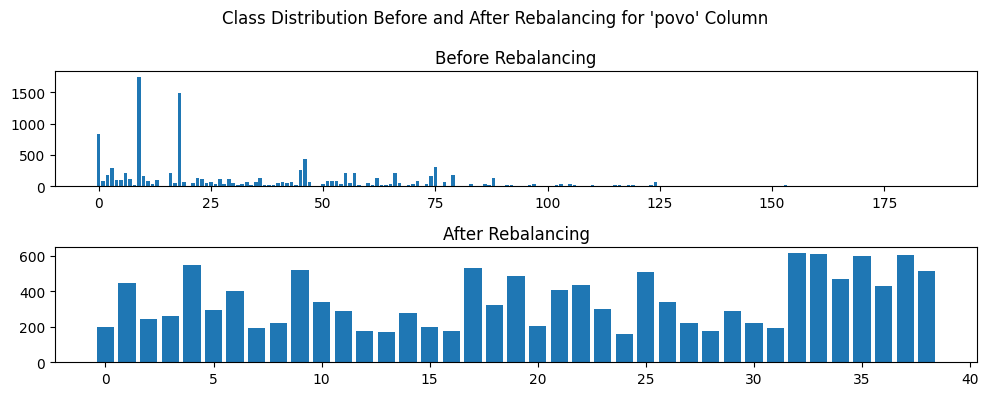

In [10]:
# Plotting old and new class distributions
plot_class_distributions(povo_categories, povo_filtered_categories, labels_minority, \
                         labels_majority, threshold_multiplier, 'povo')

In [11]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
povo_class_weights = compute_class_weights(povo_filtered_categories, labels_minority, \
                                           labels_majority, device, threshold_multiplier)

Training model:   5%|██▎                                          | 1/20 [04:30<1:25:45, 270.83s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1102.5018, Validation Accuracy: 0.3468


Training model:  10%|████▌                                        | 2/20 [09:01<1:21:12, 270.71s/it]

Best model saved at epoch 2
Epoch 2, Loss: 810.3684, Validation Accuracy: 0.4581


Training model:  15%|██████▊                                      | 3/20 [13:32<1:16:45, 270.93s/it]

Best model saved at epoch 3
Epoch 3, Loss: 618.3408, Validation Accuracy: 0.5182


Training model:  20%|█████████                                    | 4/20 [18:03<1:12:11, 270.73s/it]

Best model saved at epoch 4
Epoch 4, Loss: 455.8129, Validation Accuracy: 0.5507


Training model:  25%|███████████▎                                 | 5/20 [22:34<1:07:45, 271.01s/it]

Best model saved at epoch 5
Epoch 5, Loss: 321.4459, Validation Accuracy: 0.6128


Training model:  30%|█████████████▌                               | 6/20 [26:45<1:01:40, 264.35s/it]

Best model saved at epoch 6
Epoch 6, Loss: 218.8105, Validation Accuracy: 0.6276


Training model:  35%|████████████████▍                              | 7/20 [30:52<56:02, 258.62s/it]

Best model saved at epoch 7
Epoch 7, Loss: 142.9365, Validation Accuracy: 0.6365


Training model:  40%|██████████████████▊                            | 8/20 [34:59<50:59, 254.93s/it]

Best model saved at epoch 8
Epoch 8, Loss: 95.1069, Validation Accuracy: 0.6512


Training model:  45%|█████████████████████▏                         | 9/20 [39:05<46:10, 251.89s/it]

Epoch 9, Loss: 61.2062, Validation Accuracy: 0.6512


Training model:  50%|███████████████████████                       | 10/20 [43:09<41:35, 249.59s/it]

Epoch 10, Loss: 39.8699, Validation Accuracy: 0.6443


Training model:  55%|█████████████████████████▎                    | 11/20 [47:14<37:14, 248.30s/it]

Best model saved at epoch 11
Epoch 11, Loss: 27.6230, Validation Accuracy: 0.6542


Training model:  60%|███████████████████████████▌                  | 12/20 [51:20<32:59, 247.41s/it]

Best model saved at epoch 12
Epoch 12, Loss: 19.8592, Validation Accuracy: 0.6621


Training model:  65%|█████████████████████████████▉                | 13/20 [55:22<28:41, 245.98s/it]

Epoch 13, Loss: 14.8709, Validation Accuracy: 0.6601


Training model:  70%|████████████████████████████████▏             | 14/20 [59:27<24:33, 245.64s/it]

Best model saved at epoch 14
Epoch 14, Loss: 11.4198, Validation Accuracy: 0.6690


Training model:  75%|█████████████████████████████████           | 15/20 [1:03:28<20:20, 244.07s/it]

Epoch 15, Loss: 9.0037, Validation Accuracy: 0.6591


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:07:28<16:11, 242.96s/it]

Epoch 16, Loss: 34.2911, Validation Accuracy: 0.5852


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:11:28<12:06, 242.09s/it]

Epoch 17, Loss: 53.4447, Validation Accuracy: 0.6246


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:15:28<08:02, 241.31s/it]

Epoch 18, Loss: 14.5298, Validation Accuracy: 0.6591


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [1:19:28<04:00, 240.87s/it]

Epoch 19, Loss: 6.8854, Validation Accuracy: 0.6591


Training model: 100%|████████████████████████████████████████████| 20/20 [1:23:27<00:00, 250.39s/it]


Epoch 20, Loss: 3.4303, Validation Accuracy: 0.6591


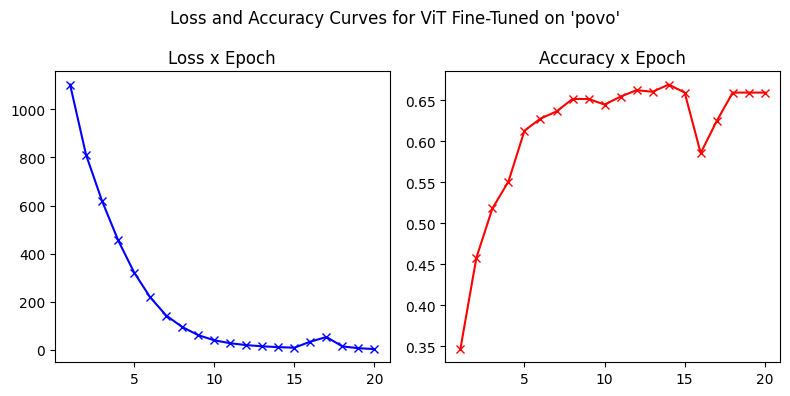

Validation accuracy: 0.6689453125
Validation average per class precision: 0.2776
Validation average per class recall: 0.2853



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test accuracy: 0.6779059171676636
Test average per class precision: 0.2808
Test average per class recall: 0.2793

Test average precision on filtered classes: 0.586224897358662
Test average recall on filtered classes: 0.6123807586920567


In [12]:
# Recreating datasets for proper training and testing
povo_train_val_labels = povo_labels.copy()
povo_test_labels_aux = random.sample(list(povo_train_val_labels), \
                                     int(0.1*len(povo_train_val_labels)))
povo_test_labels = {}
for key in povo_test_labels_aux:
    povo_test_labels[key] = povo_train_val_labels[key]
    del povo_train_val_labels[key]
    
povo_train_val_dataset = ImageDataset(povo_train_val_labels, transform=vit_transform, \
                                      augment=False)
povo_test_dataset = ImageDataset(povo_test_labels, transform=vit_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 20
num_classes = ind_df['povo'].dropna().nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=5e-5, weight_decay=2e-6)
model_name = 'vit_povo'
column_name = 'povo'

test_prec, test_rec = execute_train_test(povo_train_val_dataset, povo_test_dataset, device, \
                                         batch_size, epochs, num_classes, model, criterion, \
                                         opt, model_name, column_name)
prec_rec_on_selected_classes(povo_categories, povo_filtered_categories, test_prec, test_rec)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [06:49<2:09:44, 409.73s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1394.1341, Validation Accuracy: 0.4147


Training model:  10%|████▌                                        | 2/20 [13:36<2:02:26, 408.14s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1062.2988, Validation Accuracy: 0.5274


Training model:  15%|██████▊                                      | 3/20 [20:22<1:55:23, 407.24s/it]

Best model saved at epoch 3
Epoch 3, Loss: 747.8844, Validation Accuracy: 0.6103


Training model:  20%|█████████                                    | 4/20 [27:08<1:48:27, 406.71s/it]

Best model saved at epoch 4
Epoch 4, Loss: 450.0206, Validation Accuracy: 0.6526


Training model:  25%|███████████▎                                 | 5/20 [33:53<1:41:30, 406.06s/it]

Best model saved at epoch 5
Epoch 5, Loss: 231.0672, Validation Accuracy: 0.6886


Training model:  30%|█████████████▌                               | 6/20 [40:33<1:34:12, 403.78s/it]

Best model saved at epoch 6
Epoch 6, Loss: 111.0099, Validation Accuracy: 0.7027


Training model:  35%|███████████████▋                             | 7/20 [47:15<1:27:22, 403.28s/it]

Epoch 7, Loss: 60.3167, Validation Accuracy: 0.6823


Training model:  40%|██████████████████                           | 8/20 [53:58<1:20:40, 403.39s/it]

Epoch 8, Loss: 41.0099, Validation Accuracy: 0.6839


Training model:  45%|███████████████████▎                       | 9/20 [1:00:40<1:13:52, 402.93s/it]

Epoch 9, Loss: 30.6766, Validation Accuracy: 0.6964


Training model:  45%|███████████████████▎                       | 9/20 [1:07:23<1:22:21, 449.26s/it]


Early-stopping training!


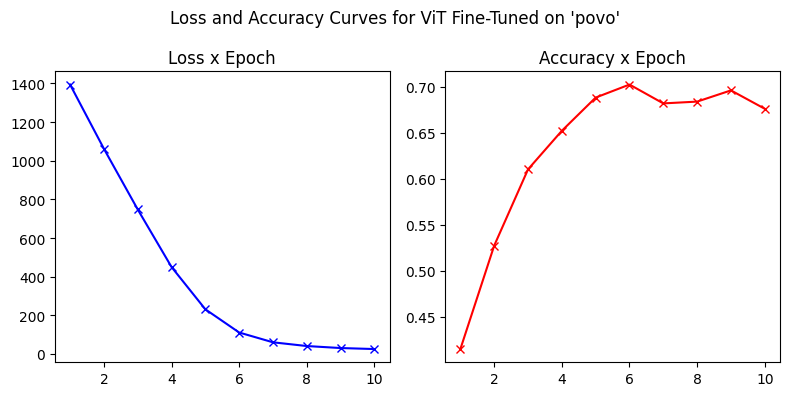

Validation accuracy: 0.70263671875
Validation average per class precision: 0.7049
Validation average per class recall: 0.6685

Test accuracy: 0.7108014225959778
Test average per class precision: 0.7407
Test average per class recall: 0.7197



Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [02:44<00:00,  7.16s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [13]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 32
epochs = 20
num_classes = len(povo_filtered_categories)
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'balanced_vit_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset)

povo_vit_trimap, povo_vit_tsne, \
povo_vit_umap, povo_image_indices = compute_classifier_embeddings(povo_dataloader, model, \
                                                                  device)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [05:21<1:41:50, 321.63s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1447.4091, Validation Accuracy: 0.3803


Training model:  10%|████▌                                        | 2/20 [10:48<1:37:30, 325.00s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1181.9487, Validation Accuracy: 0.4836


Training model:  15%|██████▊                                      | 3/20 [16:10<1:31:41, 323.60s/it]

Best model saved at epoch 3
Epoch 3, Loss: 924.2120, Validation Accuracy: 0.5743


Training model:  20%|█████████                                    | 4/20 [21:32<1:26:07, 322.99s/it]

Best model saved at epoch 4
Epoch 4, Loss: 658.1516, Validation Accuracy: 0.6369


Training model:  25%|███████████▎                                 | 5/20 [26:54<1:20:36, 322.46s/it]

Best model saved at epoch 5
Epoch 5, Loss: 412.8783, Validation Accuracy: 0.6620


Training model:  30%|█████████████▌                               | 6/20 [32:16<1:15:13, 322.42s/it]

Best model saved at epoch 6
Epoch 6, Loss: 227.9159, Validation Accuracy: 0.6823


Training model:  35%|███████████████▋                             | 7/20 [37:38<1:09:49, 322.28s/it]

Best model saved at epoch 7
Epoch 7, Loss: 117.4413, Validation Accuracy: 0.6854


Training model:  40%|██████████████████                           | 8/20 [42:59<1:04:22, 321.91s/it]

Best model saved at epoch 8
Epoch 8, Loss: 63.5065, Validation Accuracy: 0.6917


Training model:  45%|█████████████████████▏                         | 9/20 [48:21<59:01, 321.92s/it]

Epoch 9, Loss: 38.3382, Validation Accuracy: 0.6917


Training model:  50%|███████████████████████                       | 10/20 [53:43<53:39, 321.91s/it]

Best model saved at epoch 10
Epoch 10, Loss: 24.6795, Validation Accuracy: 0.6948


Training model:  55%|█████████████████████████▎                    | 11/20 [59:14<48:42, 324.74s/it]

Best model saved at epoch 11
Epoch 11, Loss: 17.9753, Validation Accuracy: 0.6980


Training model:  60%|██████████████████████████▍                 | 12/20 [1:04:40<43:18, 324.85s/it]

Best model saved at epoch 12
Epoch 12, Loss: 12.3040, Validation Accuracy: 0.6995


Training model:  65%|████████████████████████████▌               | 13/20 [1:10:06<37:57, 325.40s/it]

Epoch 13, Loss: 10.5897, Validation Accuracy: 0.6995


Training model:  70%|██████████████████████████████▊             | 14/20 [1:15:30<32:30, 325.06s/it]

Best model saved at epoch 14
Epoch 14, Loss: 7.3501, Validation Accuracy: 0.7011


Training model:  75%|█████████████████████████████████           | 15/20 [1:20:50<26:56, 323.38s/it]

Epoch 15, Loss: 8.4645, Validation Accuracy: 0.6995


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:26:08<21:27, 321.83s/it]

Epoch 16, Loss: 5.2295, Validation Accuracy: 0.6901


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:31:28<16:03, 321.30s/it]

Epoch 17, Loss: 4.9203, Validation Accuracy: 0.6980


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:36:51<10:43, 321.83s/it]

Best model saved at epoch 18
Epoch 18, Loss: 4.0291, Validation Accuracy: 0.7105


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [1:42:12<05:21, 321.38s/it]

Epoch 19, Loss: 2.2449, Validation Accuracy: 0.7105


Training model: 100%|████████████████████████████████████████████| 20/20 [1:47:35<00:00, 322.76s/it]


Epoch 20, Loss: 2.3229, Validation Accuracy: 0.7011


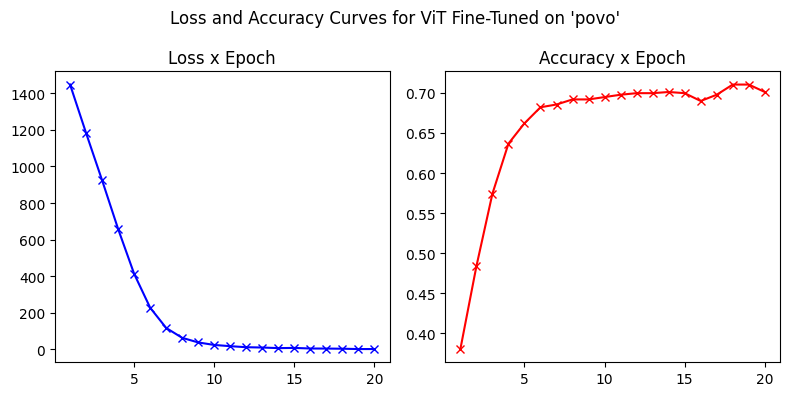

Validation accuracy: 0.71044921875
Validation average per class precision: 0.7021
Validation average per class recall: 0.6733



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test accuracy: 0.7108014225959778
Test average per class precision: 0.7227
Test average per class recall: 0.7040



In [14]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 32
epochs = 20
num_classes = len(povo_filtered_categories)
freeze = 7
model = ViTClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'frozen_vit_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset)

# Cleaning up memory
clean_mem([model])

#### *categoria* Column

In [15]:
# Now rebalancing the 'categoria' column
categoria_labels, categoria_name_to_num, categoria_num_to_name = \
preparing_image_labels(ind_df, 'categoria')
categoria_dataset = ImageDataset(categoria_labels, transform=vit_transform)
categoria_dataloader = DataLoader(categoria_dataset, batch_size=512, shuffle=True, \
                                  num_workers=0, pin_memory=True)

categoria_categories, categories_keys, categories_freq, qs, \
masks = study_class_distribution(categoria_labels)

# Filtering out 'etnobotânica' (and 'armas')
filter_out = [categoria_name_to_num['etnobotânica']]
categoria_filtered_categories = {}
categoria_filtered_categories_names = {}
for c in set(categoria_name_to_num.values()) - set(filter_out):
    categoria_filtered_categories[categories_keys[c]] = \
    categoria_categories[categories_keys[c]]
    
    categoria_filtered_categories_names[categoria_num_to_name[categories_keys[c]]] = \
    categoria_categories[categories_keys[c]]

Quantile X Data Percentage:
Q-10: 216.60, 99.71% of data
Q-25: 507.50, 93.33% of data
Q-50: 1060.50, 79.68% of data
Q-75: 1344.50, 58.09% of data
Q-90: 2270.70, 26.50% of data



In [16]:
# Filtering dataframe for selected categories
threshold_multiplier = 1.5
minority_classes, majority_classes, labels_minority, labels_majority, val_labels, \
test_labels, categoria_augmented_dataset, categoria_balanced_val_dataset, \
categoria_balanced_test_dataset = \
filter_image_data_distribution(ind_df, categoria_filtered_categories_names, vit_transform, \
                               threshold_multiplier, 'categoria')

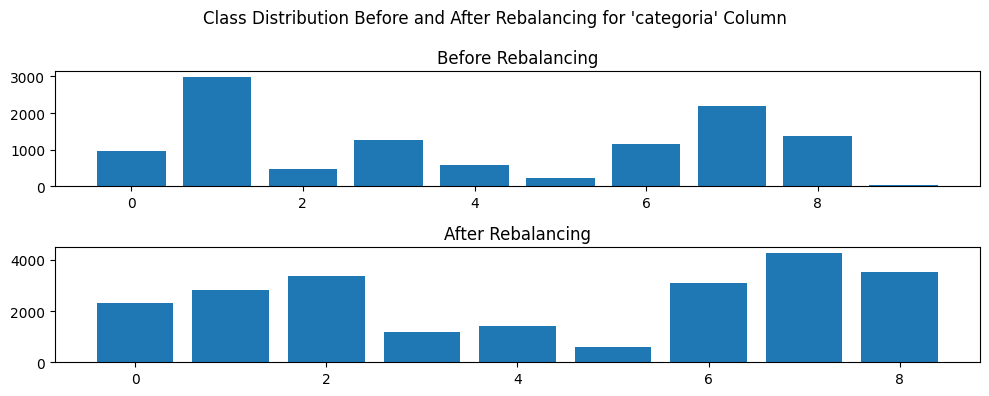

In [17]:
# Plotting old and new class distributions
plot_class_distributions(categoria_categories, categoria_filtered_categories, \
                         labels_minority, labels_majority, threshold_multiplier, 'categoria')

In [18]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
categoria_class_weights = compute_class_weights(categoria_filtered_categories, \
                                                labels_minority, labels_majority, device, \
                                                threshold_multiplier)

Training model:   5%|██▎                                          | 1/20 [04:04<1:17:19, 244.17s/it]

Best model saved at epoch 1
Epoch 1, Loss: 481.6194, Validation Accuracy: 0.6857


Training model:  10%|████▌                                        | 2/20 [08:07<1:13:07, 243.78s/it]

Best model saved at epoch 2
Epoch 2, Loss: 299.6422, Validation Accuracy: 0.7901


Training model:  15%|██████▊                                      | 3/20 [12:10<1:08:58, 243.47s/it]

Best model saved at epoch 3
Epoch 3, Loss: 211.8080, Validation Accuracy: 0.8345


Training model:  20%|█████████                                    | 4/20 [16:14<1:04:54, 243.41s/it]

Best model saved at epoch 4
Epoch 4, Loss: 152.9994, Validation Accuracy: 0.8443


Training model:  25%|███████████▎                                 | 5/20 [20:14<1:00:32, 242.20s/it]

Best model saved at epoch 5
Epoch 5, Loss: 110.5643, Validation Accuracy: 0.8670


Training model:  30%|██████████████                                 | 6/20 [24:11<56:08, 240.62s/it]

Epoch 6, Loss: 79.0853, Validation Accuracy: 0.8611


Training model:  35%|████████████████▍                              | 7/20 [28:10<51:58, 239.89s/it]

Epoch 7, Loss: 58.9267, Validation Accuracy: 0.8640


Training model:  40%|██████████████████▊                            | 8/20 [32:08<47:54, 239.54s/it]

Best model saved at epoch 8
Epoch 8, Loss: 45.0166, Validation Accuracy: 0.8739


Training model:  45%|█████████████████████▏                         | 9/20 [36:06<43:46, 238.79s/it]

Epoch 9, Loss: 34.8262, Validation Accuracy: 0.8631


Training model:  50%|███████████████████████                       | 10/20 [40:03<39:43, 238.39s/it]

Epoch 10, Loss: 28.7394, Validation Accuracy: 0.8611


Training model:  55%|█████████████████████████▎                    | 11/20 [44:01<35:43, 238.22s/it]

Epoch 11, Loss: 22.8623, Validation Accuracy: 0.8739


Training model:  55%|█████████████████████████▎                    | 11/20 [47:59<39:15, 261.74s/it]

Early-stopping training!


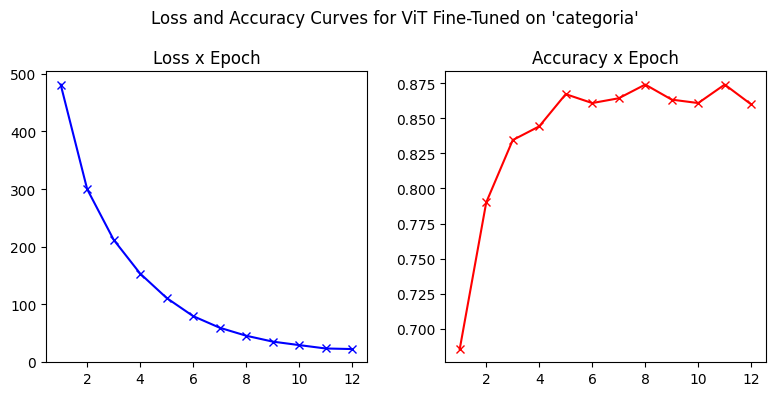

/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Validation accuracy: 0.8740234375
Validation average per class precision: 0.7779
Validation average per class recall: 0.7549

Test accuracy: 0.8713398575782776
Test average per class precision: 0.7934
Test average per class recall: 0.7491

Test average precision on filtered classes: 0.8815947108798556
Test average recall on filtered classes: 0.8323278294669257


In [19]:
# Recreating datasets for proper training and testing
categoria_train_val_labels = categoria_labels.copy()
categoria_test_labels_aux = random.sample(list(categoria_train_val_labels), \
                                          int(0.1*len(categoria_train_val_labels)))
categoria_test_labels = {}
for key in categoria_test_labels_aux:
    categoria_test_labels[key] = categoria_train_val_labels[key]
    del categoria_train_val_labels[key]
    
categoria_train_val_dataset = ImageDataset(categoria_train_val_labels, \
                                           transform=vit_transform, augment=False)
categoria_test_dataset = ImageDataset(categoria_test_labels, \
                                      transform=vit_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 20
num_classes = ind_df['categoria'].dropna().nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-5, weight_decay=2e-6)
model_name = 'vit_categoria'
column_name = 'categoria'

test_prec, test_rec = execute_train_test(categoria_train_val_dataset, categoria_test_dataset, \
                                         device, batch_size, epochs, num_classes, model, \
                                         criterion, opt, model_name, column_name)
prec_rec_on_selected_classes(categoria_categories, categoria_filtered_categories, test_prec, \
                             test_rec)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [11:25<3:37:11, 685.89s/it]

Best model saved at epoch 1
Epoch 1, Loss: 2470.0438, Validation Accuracy: 0.7010


Training model:  10%|████▌                                        | 2/20 [22:51<3:25:44, 685.81s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1477.4549, Validation Accuracy: 0.7838


Training model:  15%|██████▊                                      | 3/20 [34:18<3:14:26, 686.28s/it]

Best model saved at epoch 3
Epoch 3, Loss: 1017.0896, Validation Accuracy: 0.8114


Training model:  20%|█████████                                    | 4/20 [45:51<3:03:45, 689.06s/it]

Best model saved at epoch 4
Epoch 4, Loss: 719.6965, Validation Accuracy: 0.8546


Training model:  25%|███████████▎                                 | 5/20 [57:31<2:53:14, 692.99s/it]

Best model saved at epoch 5
Epoch 5, Loss: 501.7788, Validation Accuracy: 0.8638


Training model:  30%|████████████▉                              | 6/20 [1:09:03<2:41:35, 692.57s/it]

Best model saved at epoch 6
Epoch 6, Loss: 345.7604, Validation Accuracy: 0.8730


Training model:  35%|███████████████                            | 7/20 [1:20:39<2:30:16, 693.58s/it]

Best model saved at epoch 7
Epoch 7, Loss: 241.8145, Validation Accuracy: 0.8749


Training model:  40%|█████████████████▏                         | 8/20 [1:32:15<2:18:54, 694.53s/it]

Epoch 8, Loss: 168.2509, Validation Accuracy: 0.8694


Training model:  45%|███████████████████▎                       | 9/20 [1:43:45<2:07:02, 692.98s/it]

Best model saved at epoch 9
Epoch 9, Loss: 116.8427, Validation Accuracy: 0.8786


Training model:  50%|█████████████████████                     | 10/20 [1:55:18<1:55:30, 693.01s/it]

Best model saved at epoch 10
Epoch 10, Loss: 85.7160, Validation Accuracy: 0.8813


Training model:  55%|███████████████████████                   | 11/20 [2:06:58<1:44:15, 695.10s/it]

Best model saved at epoch 11
Epoch 11, Loss: 67.1701, Validation Accuracy: 0.8832


Training model:  60%|█████████████████████████▏                | 12/20 [2:18:36<1:32:47, 695.98s/it]

Epoch 12, Loss: 48.7387, Validation Accuracy: 0.8795


Training model:  65%|███████████████████████████▎              | 13/20 [2:30:01<1:20:50, 692.88s/it]

Epoch 13, Loss: 43.7448, Validation Accuracy: 0.8749


Training model:  70%|█████████████████████████████▍            | 14/20 [2:41:34<1:09:17, 692.84s/it]

Epoch 14, Loss: 35.1800, Validation Accuracy: 0.8813


Training model:  75%|█████████████████████████████████           | 15/20 [2:53:11<57:50, 694.14s/it]

Epoch 15, Loss: 25.5388, Validation Accuracy: 0.8804


Training model:  80%|███████████████████████████████████▏        | 16/20 [3:04:41<46:11, 692.92s/it]

Epoch 16, Loss: 25.3016, Validation Accuracy: 0.8832


Training model:  85%|█████████████████████████████████████▍      | 17/20 [3:16:17<34:41, 693.71s/it]

Best model saved at epoch 17
Epoch 17, Loss: 22.2629, Validation Accuracy: 0.8878


Training model:  90%|███████████████████████████████████████▌    | 18/20 [3:27:58<23:11, 695.89s/it]

Epoch 18, Loss: 15.8997, Validation Accuracy: 0.8822


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [3:39:37<11:36, 696.91s/it]

Epoch 19, Loss: 22.5181, Validation Accuracy: 0.8813


Training model: 100%|████████████████████████████████████████████| 20/20 [3:51:12<00:00, 693.63s/it]


Epoch 20, Loss: 11.8202, Validation Accuracy: 0.8813


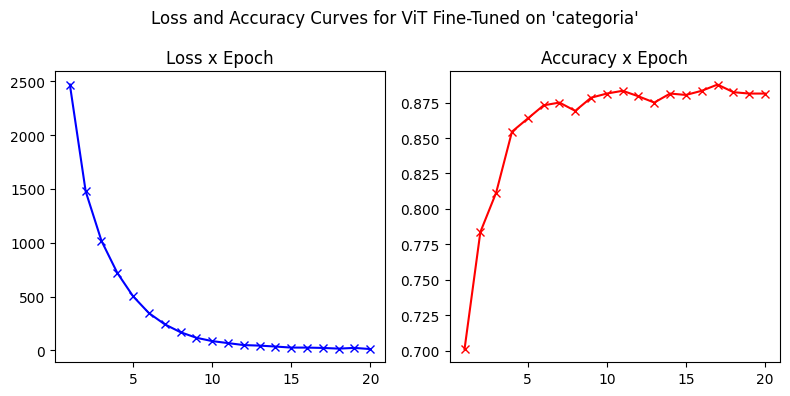

Validation accuracy: 0.8876953125
Validation average per class precision: 0.8828
Validation average per class recall: 0.8610

Test accuracy: 0.9008179903030396
Test average per class precision: 0.8874
Test average per class recall: 0.8622



Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [02:44<00:00,  7.14s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [20]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-6)
model_name = 'balanced_vit_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset)

categoria_vit_trimap, categoria_vit_tsne, categoria_vit_umap, \
categoria_image_indices = compute_classifier_embeddings(categoria_dataloader, model, device)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [09:14<2:55:41, 554.83s/it]

Best model saved at epoch 1
Epoch 1, Loss: 2677.7128, Validation Accuracy: 0.6412


Training model:  10%|████▌                                        | 2/20 [18:23<2:45:21, 551.22s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1806.6297, Validation Accuracy: 0.7341


Training model:  15%|██████▊                                      | 3/20 [27:35<2:36:19, 551.71s/it]

Best model saved at epoch 3
Epoch 3, Loss: 1302.9670, Validation Accuracy: 0.7737


Training model:  20%|█████████                                    | 4/20 [36:48<2:27:13, 552.07s/it]

Best model saved at epoch 4
Epoch 4, Loss: 990.6553, Validation Accuracy: 0.8077


Training model:  25%|███████████▎                                 | 5/20 [46:00<2:17:58, 551.92s/it]

Best model saved at epoch 5
Epoch 5, Loss: 762.1822, Validation Accuracy: 0.8353


Training model:  30%|█████████████▌                               | 6/20 [55:11<2:08:42, 551.62s/it]

Best model saved at epoch 6
Epoch 6, Loss: 582.2694, Validation Accuracy: 0.8491


Training model:  35%|███████████████                            | 7/20 [1:04:25<1:59:43, 552.56s/it]

Best model saved at epoch 7
Epoch 7, Loss: 439.3563, Validation Accuracy: 0.8657


Training model:  40%|█████████████████▏                         | 8/20 [1:13:37<1:50:27, 552.31s/it]

Best model saved at epoch 8
Epoch 8, Loss: 323.7937, Validation Accuracy: 0.8767


Training model:  45%|███████████████████▎                       | 9/20 [1:22:49<1:41:15, 552.30s/it]

Best model saved at epoch 9
Epoch 9, Loss: 235.5568, Validation Accuracy: 0.8804


Training model:  50%|█████████████████████                     | 10/20 [1:31:52<1:31:34, 549.44s/it]

Best model saved at epoch 10
Epoch 10, Loss: 168.7509, Validation Accuracy: 0.8868


Training model:  55%|███████████████████████                   | 11/20 [1:40:58<1:22:15, 548.40s/it]

Epoch 11, Loss: 118.2363, Validation Accuracy: 0.8795


Training model:  60%|█████████████████████████▏                | 12/20 [1:49:58<1:12:45, 545.65s/it]

Best model saved at epoch 12
Epoch 12, Loss: 85.7815, Validation Accuracy: 0.8878


Training model:  65%|███████████████████████████▎              | 13/20 [1:59:00<1:03:32, 544.57s/it]

Epoch 13, Loss: 63.2895, Validation Accuracy: 0.8832


Training model:  70%|██████████████████████████████▊             | 14/20 [2:08:02<54:24, 544.02s/it]

Epoch 14, Loss: 45.4388, Validation Accuracy: 0.8822


Training model:  75%|█████████████████████████████████           | 15/20 [2:17:09<45:24, 544.89s/it]

Epoch 15, Loss: 36.6363, Validation Accuracy: 0.8850


Training model:  80%|███████████████████████████████████▏        | 16/20 [2:26:15<36:20, 545.13s/it]

Epoch 16, Loss: 28.9216, Validation Accuracy: 0.8813


Training model:  85%|█████████████████████████████████████▍      | 17/20 [2:35:24<27:18, 546.22s/it]

Epoch 17, Loss: 21.5140, Validation Accuracy: 0.8804


Training model:  90%|███████████████████████████████████████▌    | 18/20 [2:44:41<18:19, 549.57s/it]

Epoch 18, Loss: 16.8335, Validation Accuracy: 0.8868


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [2:53:58<09:11, 551.76s/it]

Epoch 19, Loss: 14.4445, Validation Accuracy: 0.8850


Training model: 100%|████████████████████████████████████████████| 20/20 [3:03:06<00:00, 549.34s/it]


Epoch 20, Loss: 12.5410, Validation Accuracy: 0.8859


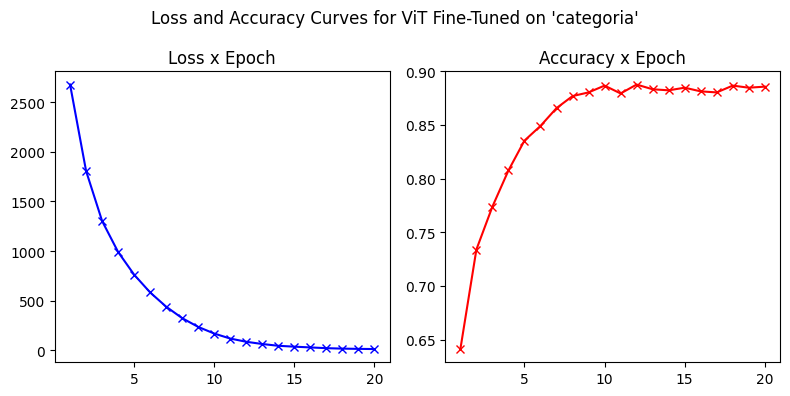

Validation accuracy: 0.8876953125
Validation average per class precision: 0.8745
Validation average per class recall: 0.8538



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test accuracy: 0.8967280387878418
Test average per class precision: 0.8909
Test average per class recall: 0.8806



In [21]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
freeze = 7
model = ViTClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-6)
model_name = 'frozen_vit_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset)

# Cleaning up memory
clean_mem([model])

#### Multi-Head Training

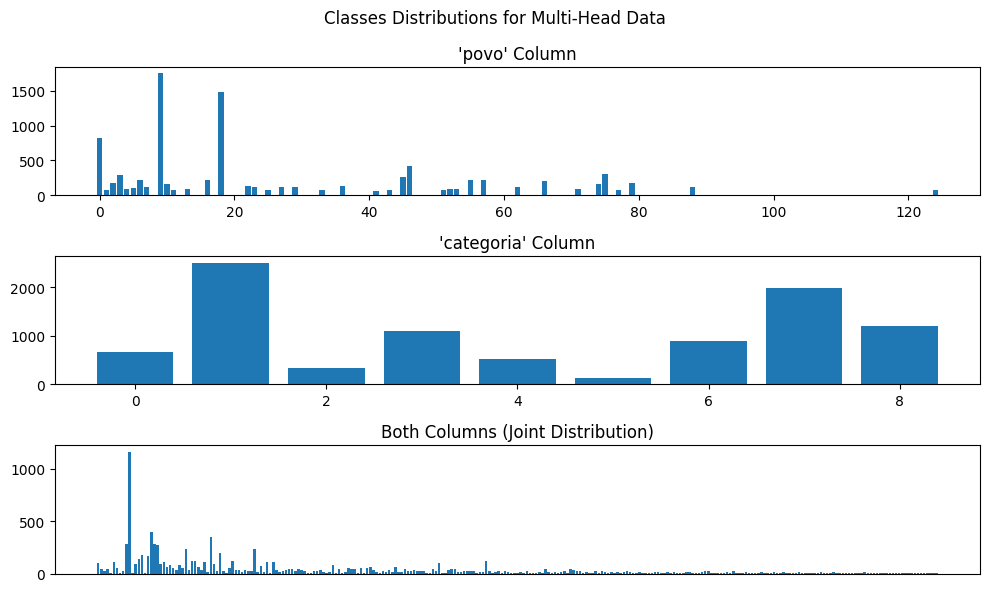

In [22]:
# Getting data that passes both heads' data-filters
povo_set = set(np.array(list(povo_labels.keys()))\
                [np.where(np.isin(np.array(list(povo_labels.values())), \
                np.array(list(povo_filtered_categories.keys()))))[0]])
categoria_set = set(np.array(list(categoria_labels.keys()))\
                    [np.where(np.isin(np.array(list(categoria_labels.values())), \
                    np.array(list(categoria_filtered_categories.keys()))))[0]])
multi_head_keys = [str(x) for x in povo_set.intersection(categoria_set)]

# Studying individual and joint classes' distributions
povo_freq = {}
categoria_freq = {}
multi_freq = {}
for key in multi_head_keys:
    try:
        povo_freq[povo_labels[key]] += 1
    except:
        povo_freq[povo_labels[key]] = 1

    try:
        categoria_freq[categoria_labels[key]] += 1
    except:
        categoria_freq[categoria_labels[key]] = 1

    try:
        multi_freq[f'{(povo_labels[key], categoria_labels[key])}'] += 1
    except:
        multi_freq[f'{(povo_labels[key], categoria_labels[key])}'] = 1

# Utility function to plot rows on data distribution plot
def row_bar_plot(col_freq, name, row, rows=3, cols=1, remove_xticks=False):
    plt.subplot(rows, cols, row)
    plt.bar(list(col_freq.keys()), list(col_freq.values()))
    plt.title(name)

    if remove_xticks:
        plt.xlabel("")
        plt.xticks([])

plt.figure(figsize=(10,6))
plt.suptitle('Classes Distributions for Multi-Head Data')

row_bar_plot(povo_freq, "'povo' Column", 1)
row_bar_plot(categoria_freq, "'categoria' Column", 2)
row_bar_plot(multi_freq, "Both Columns (Joint Distribution)", 3, remove_xticks=True)

plt.tight_layout()
plt.show()

In [23]:
# Because of the even worse degree of unbalanced data on the joint distribution, we balance
# the dataset taking the 'povo' column into consideration and study the new joint distribution
multi_povo_labels = {}
multi_categoria_labels = {}
for key in multi_head_keys:
    multi_povo_labels[key] = povo_labels[key]
    multi_categoria_labels[key] = categoria_labels[key]

# Reusing previous dataset infrastructure to build multi-label dataset
multi_povo_categories, categories_keys, categories_freq, \
qs, masks = study_class_distribution(multi_povo_labels)
multi_povo_filtered_categories = multi_povo_categories
multi_povo_filtered_categories_names = {}
for c in categories_keys:
    multi_povo_filtered_categories_names[povo_num_to_name[c]] = multi_povo_categories[c]

multi_categoria_categories, categories_keys, categories_freq, \
qs, masks = study_class_distribution(multi_categoria_labels)
multi_categoria_filtered_categories = multi_categoria_categories
multi_categoria_filtered_categories_names = {}
for c in categories_keys:
    multi_categoria_filtered_categories_names[categoria_num_to_name[c]] = \
    multi_categoria_categories[c]

Quantile X Data Percentage:
Q-10: 75.00, 96.14% of data
Q-25: 86.00, 91.77% of data
Q-50: 123.00, 80.30% of data
Q-75: 216.50, 64.05% of data
Q-90: 327.40, 47.86% of data

Quantile X Data Percentage:
Q-10: 302.40, 98.63% of data
Q-25: 515.00, 89.42% of data
Q-50: 887.00, 72.71% of data
Q-75: 1203.00, 48.06% of data
Q-90: 2089.00, 26.84% of data



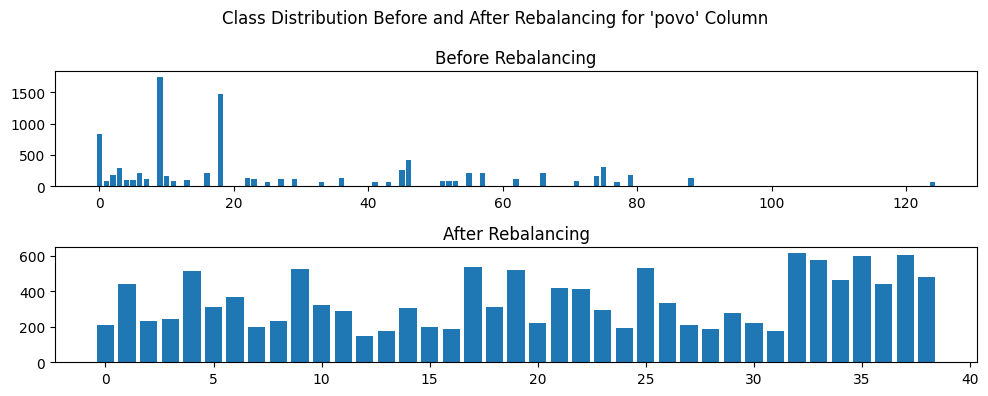

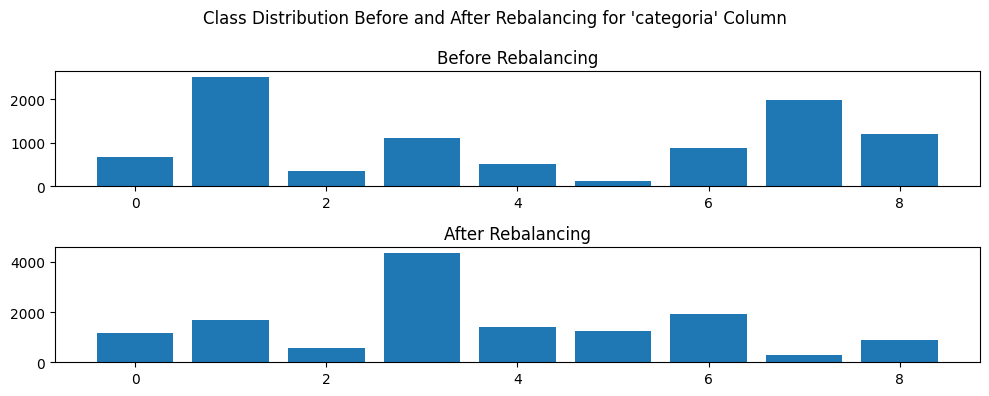

In [24]:
# Filtering dataframe for selected categories
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, multi_augmented_dataset, multi_balanced_val_dataset, \
multi_balanced_test_dataset = \
multihead_filter_image_data_distribution(ind_df, [multi_povo_filtered_categories_names, \
                                         multi_categoria_filtered_categories_names], \
                                         vit_transform, threshold_multiplier, \
                                         ['povo', 'categoria'])

# Plotting old and new class distributions
multihead_plot_class_distributions(multi_povo_categories, multi_povo_filtered_categories, \
                                   labels_minority, labels_majority, threshold_multiplier, \
                                   'povo')

multihead_plot_class_distributions(multi_categoria_categories, \
                                   multi_categoria_filtered_categories, \
                                   labels_minority, labels_majority, threshold_multiplier, \
                                   'categoria')

In [25]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
multi_povo_class_weights = multihead_compute_class_weights(multi_povo_filtered_categories, \
                                                           labels_minority, labels_majority, \
                                                           device, threshold_multiplier, \
                                                           'povo')

multi_categoria_class_weights = \
multihead_compute_class_weights(multi_categoria_filtered_categories, labels_minority, \
                                labels_majority, device, threshold_multiplier,'categoria')

Training model:   3%|█▌                                           | 1/30 [07:12<3:28:53, 432.20s/it]

Best model saved at epoch 1
Epoch 1, Combined Loss: 1753.7819, Validation Average Accuracy: 0.4746


Training model:   7%|███                                          | 2/30 [14:16<3:19:31, 427.57s/it]

Best model saved at epoch 2
Epoch 2, Combined Loss: 1224.8755, Validation Average Accuracy: 0.5420


Training model:  10%|████▌                                        | 3/30 [21:26<3:12:47, 428.44s/it]

Best model saved at epoch 3
Epoch 3, Combined Loss: 974.1917, Validation Average Accuracy: 0.5654


Training model:  13%|██████                                       | 4/30 [28:36<3:05:59, 429.22s/it]

Best model saved at epoch 4
Epoch 4, Combined Loss: 836.4347, Validation Average Accuracy: 0.6011


Training model:  17%|███████▌                                     | 5/30 [35:42<2:58:23, 428.13s/it]

Best model saved at epoch 5
Epoch 5, Combined Loss: 737.2963, Validation Average Accuracy: 0.6299


Training model:  20%|█████████                                    | 6/30 [42:51<2:51:17, 428.25s/it]

Best model saved at epoch 6
Epoch 6, Combined Loss: 653.8029, Validation Average Accuracy: 0.6587


Training model:  23%|██████████▌                                  | 7/30 [49:55<2:43:44, 427.14s/it]

Best model saved at epoch 7
Epoch 7, Combined Loss: 567.5255, Validation Average Accuracy: 0.6816


Training model:  27%|████████████                                 | 8/30 [57:03<2:36:38, 427.18s/it]

Best model saved at epoch 8
Epoch 8, Combined Loss: 479.6929, Validation Average Accuracy: 0.7119


Training model:  30%|████████████▉                              | 9/30 [1:04:02<2:28:41, 424.82s/it]

Best model saved at epoch 9
Epoch 9, Combined Loss: 389.7716, Validation Average Accuracy: 0.7319


Training model:  33%|██████████████                            | 10/30 [1:11:00<2:20:49, 422.49s/it]

Best model saved at epoch 10
Epoch 10, Combined Loss: 305.5965, Validation Average Accuracy: 0.7490


Training model:  37%|███████████████▍                          | 11/30 [1:18:02<2:13:45, 422.42s/it]

Best model saved at epoch 11
Epoch 11, Combined Loss: 227.9722, Validation Average Accuracy: 0.7549


Training model:  40%|████████████████▊                         | 12/30 [1:25:10<2:07:13, 424.06s/it]

Best model saved at epoch 12
Epoch 12, Combined Loss: 171.0113, Validation Average Accuracy: 0.7588


Training model:  43%|██████████████████▏                       | 13/30 [1:32:13<2:00:04, 423.82s/it]

Best model saved at epoch 13
Epoch 13, Combined Loss: 117.7103, Validation Average Accuracy: 0.7773


Training model:  47%|███████████████████▌                      | 14/30 [1:39:14<1:52:48, 423.02s/it]

Best model saved at epoch 14
Epoch 14, Combined Loss: 83.2904, Validation Average Accuracy: 0.7812


Training model:  50%|█████████████████████                     | 15/30 [1:46:19<1:45:52, 423.47s/it]

Epoch 15, Combined Loss: 58.7959, Validation Average Accuracy: 0.7808


Training model:  53%|██████████████████████▍                   | 16/30 [1:53:23<1:38:53, 423.84s/it]

Best model saved at epoch 16
Epoch 16, Combined Loss: 40.9948, Validation Average Accuracy: 0.7896


Training model:  57%|███████████████████████▊                  | 17/30 [2:00:32<1:32:07, 425.18s/it]

Best model saved at epoch 17
Epoch 17, Combined Loss: 28.3964, Validation Average Accuracy: 0.7920


Training model:  60%|█████████████████████████▏                | 18/30 [2:07:33<1:24:47, 423.97s/it]

Epoch 18, Combined Loss: 21.0871, Validation Average Accuracy: 0.7881


Training model:  63%|██████████████████████████▌               | 19/30 [2:14:29<1:17:16, 421.50s/it]

Epoch 19, Combined Loss: 14.5497, Validation Average Accuracy: 0.7910


Training model:  67%|████████████████████████████              | 20/30 [2:21:23<1:09:53, 419.35s/it]

Epoch 20, Combined Loss: 16.8259, Validation Average Accuracy: 0.7485


Training model:  70%|█████████████████████████████▍            | 21/30 [2:28:20<1:02:48, 418.74s/it]

Epoch 21, Combined Loss: 12.3849, Validation Average Accuracy: 0.7891


Training model:  73%|████████████████████████████████▎           | 22/30 [2:35:17<55:45, 418.14s/it]

Epoch 22, Combined Loss: 6.2630, Validation Average Accuracy: 0.7881


Training model:  77%|█████████████████████████████████▋          | 23/30 [2:42:17<48:49, 418.56s/it]

Epoch 23, Combined Loss: 5.3305, Validation Average Accuracy: 0.7666


Training model:  80%|███████████████████████████████████▏        | 24/30 [2:49:16<41:52, 418.72s/it]

Best model saved at epoch 24
Epoch 24, Combined Loss: 11.2601, Validation Average Accuracy: 0.7925


Training model:  83%|████████████████████████████████████▋       | 25/30 [2:56:20<35:01, 420.29s/it]

Epoch 25, Combined Loss: 11.2852, Validation Average Accuracy: 0.7920


Training model:  87%|██████████████████████████████████████▏     | 26/30 [3:03:17<27:58, 419.53s/it]

Epoch 26, Combined Loss: 4.2417, Validation Average Accuracy: 0.7920


Training model:  90%|███████████████████████████████████████▌    | 27/30 [3:10:17<20:58, 419.52s/it]

Best model saved at epoch 27
Epoch 27, Combined Loss: 2.6889, Validation Average Accuracy: 0.7939


Training model:  93%|█████████████████████████████████████████   | 28/30 [3:17:21<14:01, 420.78s/it]

Best model saved at epoch 28
Epoch 28, Combined Loss: 2.5130, Validation Average Accuracy: 0.7949


Training model:  97%|██████████████████████████████████████████▌ | 29/30 [3:24:16<06:59, 419.31s/it]

Epoch 29, Combined Loss: 17.8344, Validation Average Accuracy: 0.7900


Training model: 100%|████████████████████████████████████████████| 30/30 [3:31:16<00:00, 422.54s/it]


Epoch 30, Combined Loss: 9.4573, Validation Average Accuracy: 0.7939


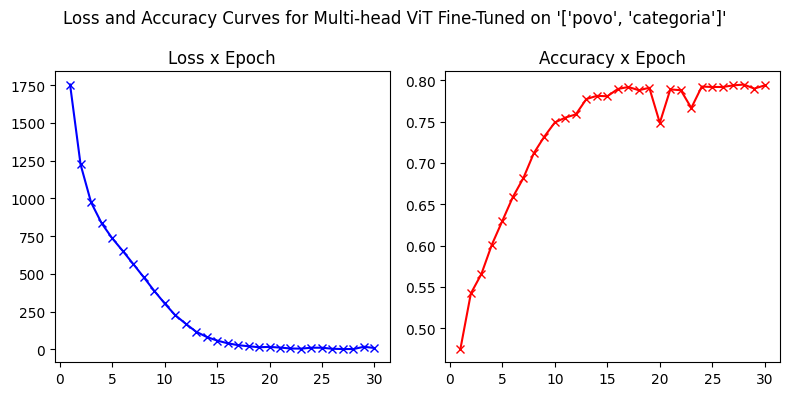

Validation 'povo' head accuracy: 0.69580078125
Validation 'categoria' head accuracy: 0.89453125
Validation average accuracy: 0.794921875

Validation 'povo' head average per class precision: 0.7130
Validation 'povo' head average per class recall: 0.6782

Validation 'categoria' head average per class precision: 0.8777
Validation 'categoria' head average per class recall: 0.8302



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:719: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test 'povo' head accuracy: 0.7040280103683472
Test 'categoria' head accuracy: 0.900175154209137
Test average accuracy: 0.80224609375

Test 'povo' head average per class precision: 0.6822
Test 'povo' head average per class recall: 0.6734

Test 'categoria' head average per class precision: 0.8760
Test 'categoria' head average per class recall: 0.8469



Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [02:46<00:00,  7.25s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [26]:
# Training multi-head model on balanced dataset to see the difference in results
batch_size = 16
epochs = 30
num_classes = [len(multi_povo_filtered_categories), len(multi_categoria_filtered_categories)]
model = ViTClassifier(num_classes[0], num_classes[1]).to(device)
criterions = [nn.CrossEntropyLoss(weight=multi_povo_class_weights), \
              nn.CrossEntropyLoss(weight=multi_categoria_class_weights)]
opt = optim.Adam(model.parameters(), lr=1e-5, weight_decay=3e-6)
model_name = 'multihead_vit'
column_names = ['povo', 'categoria']
arch_name = 'ViT'
head_weights = [0.3, 0.7]

multihead_execute_train_test(multi_augmented_dataset, multi_balanced_test_dataset, device, \
                             batch_size, epochs, num_classes, model, \
                             criterions, opt, model_name, column_names, \
                             multi_balanced_val_dataset, arch_name, head_weights)

multihead_vit_trimap, multihead_vit_tsne, multihead_vit_umap, \
multihead_image_indices = compute_classifier_embeddings(categoria_dataloader, model, device)

# Cleaning up memory
clean_mem([model])

### Visualizing and Comparing Projections

In [27]:
# Normalizing data for later plot on tool
norm_factor = 12
vanilla_vit_trimap = normalize(vanilla_vit_trimap, norm_factor)
vanilla_vit_tsne = normalize(vanilla_vit_tsne, norm_factor)
vanilla_vit_umap = normalize(vanilla_vit_umap, norm_factor)

povo_vit_trimap = normalize(povo_vit_trimap, norm_factor)
povo_vit_tsne = normalize(povo_vit_tsne, norm_factor)
povo_vit_umap = normalize(povo_vit_umap, norm_factor)

categoria_vit_trimap = normalize(categoria_vit_trimap, norm_factor)
categoria_vit_tsne = normalize(categoria_vit_tsne, norm_factor)
categoria_vit_umap = normalize(categoria_vit_umap, norm_factor)

multihead_vit_trimap = normalize(multihead_vit_trimap, norm_factor)
multihead_vit_tsne = normalize(multihead_vit_tsne, norm_factor)
multihead_vit_umap = normalize(multihead_vit_umap, norm_factor)

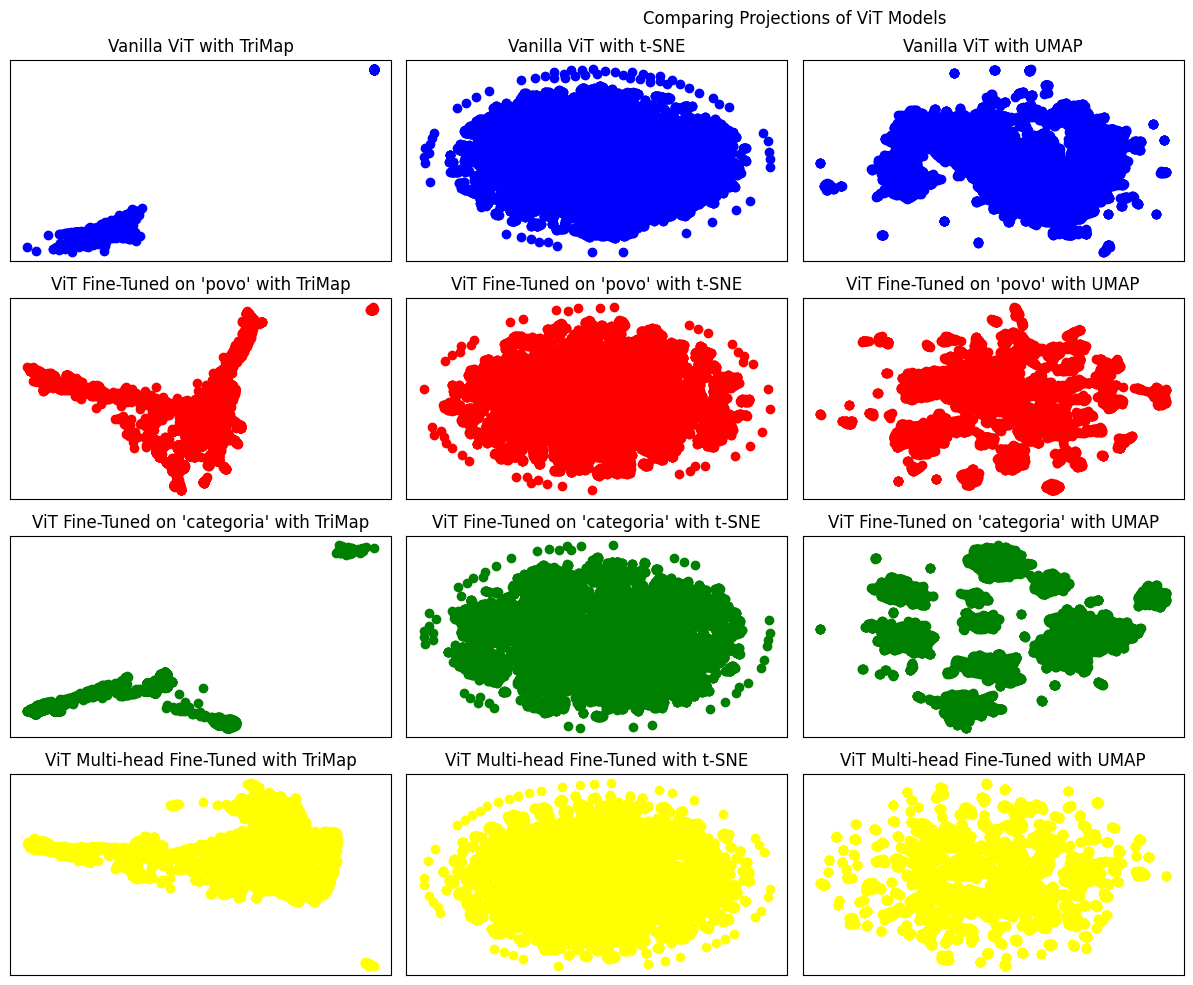

In [28]:
# Utility function to plot rows on projection comparison plot
def row_scatter_plot(projs, proj_names, row, color, rows=4, cols=4):
    for i, (proj, proj_name) in enumerate(zip(projs, proj_names)):
        plt.subplot(rows, cols, i+1+(cols*(row-1)))
        plt.scatter(proj[:, 0], proj[:, 1], c=color)
        plt.title(f"{proj_name}")
        plt.xlabel("")
        plt.ylabel("")
        plt.xticks([])
        plt.yticks([])

# Visualizing resulting projections
plt.figure(figsize=(16,10))
plt.suptitle('Comparing Projections of ViT Models')

# Plotting vanilla ViT projections
projs = [vanilla_vit_trimap, vanilla_vit_tsne, vanilla_vit_umap]
proj_names = ['Vanilla ViT with TriMap', 'Vanilla ViT with t-SNE', 'Vanilla ViT with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b')

# Plotting ViT fine-tuned on 'povo' projections
projs = [povo_vit_trimap, povo_vit_tsne, povo_vit_umap]
proj_names = ["ViT Fine-Tuned on 'povo' with TriMap", "ViT Fine-Tuned on 'povo' with t-SNE", \
              "ViT Fine-Tuned on 'povo' with UMAP"]
row_scatter_plot(projs, proj_names, 2, 'r')

# Plotting ViT fine-tuned on 'categoria' projections
projs = [categoria_vit_trimap, categoria_vit_tsne, categoria_vit_umap]
proj_names = ["ViT Fine-Tuned on 'categoria' with TriMap", \
              "ViT Fine-Tuned on 'categoria' with t-SNE", \
              "ViT Fine-Tuned on 'categoria' with UMAP"]
row_scatter_plot(projs, proj_names, 3, 'g')

# Plotting ViT fine-tuned on 'povo' and 'categoria' (multi-head) projections
projs = [multihead_vit_trimap, multihead_vit_tsne, multihead_vit_umap]
proj_names = ["ViT Multi-head Fine-Tuned with TriMap", \
              "ViT Multi-head Fine-Tuned with t-SNE", \
              "ViT Multi-head Fine-Tuned with UMAP"]
row_scatter_plot(projs, proj_names, 4, 'yellow')

plt.tight_layout()
plt.show()

### Visualizing Clusters

/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:818: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


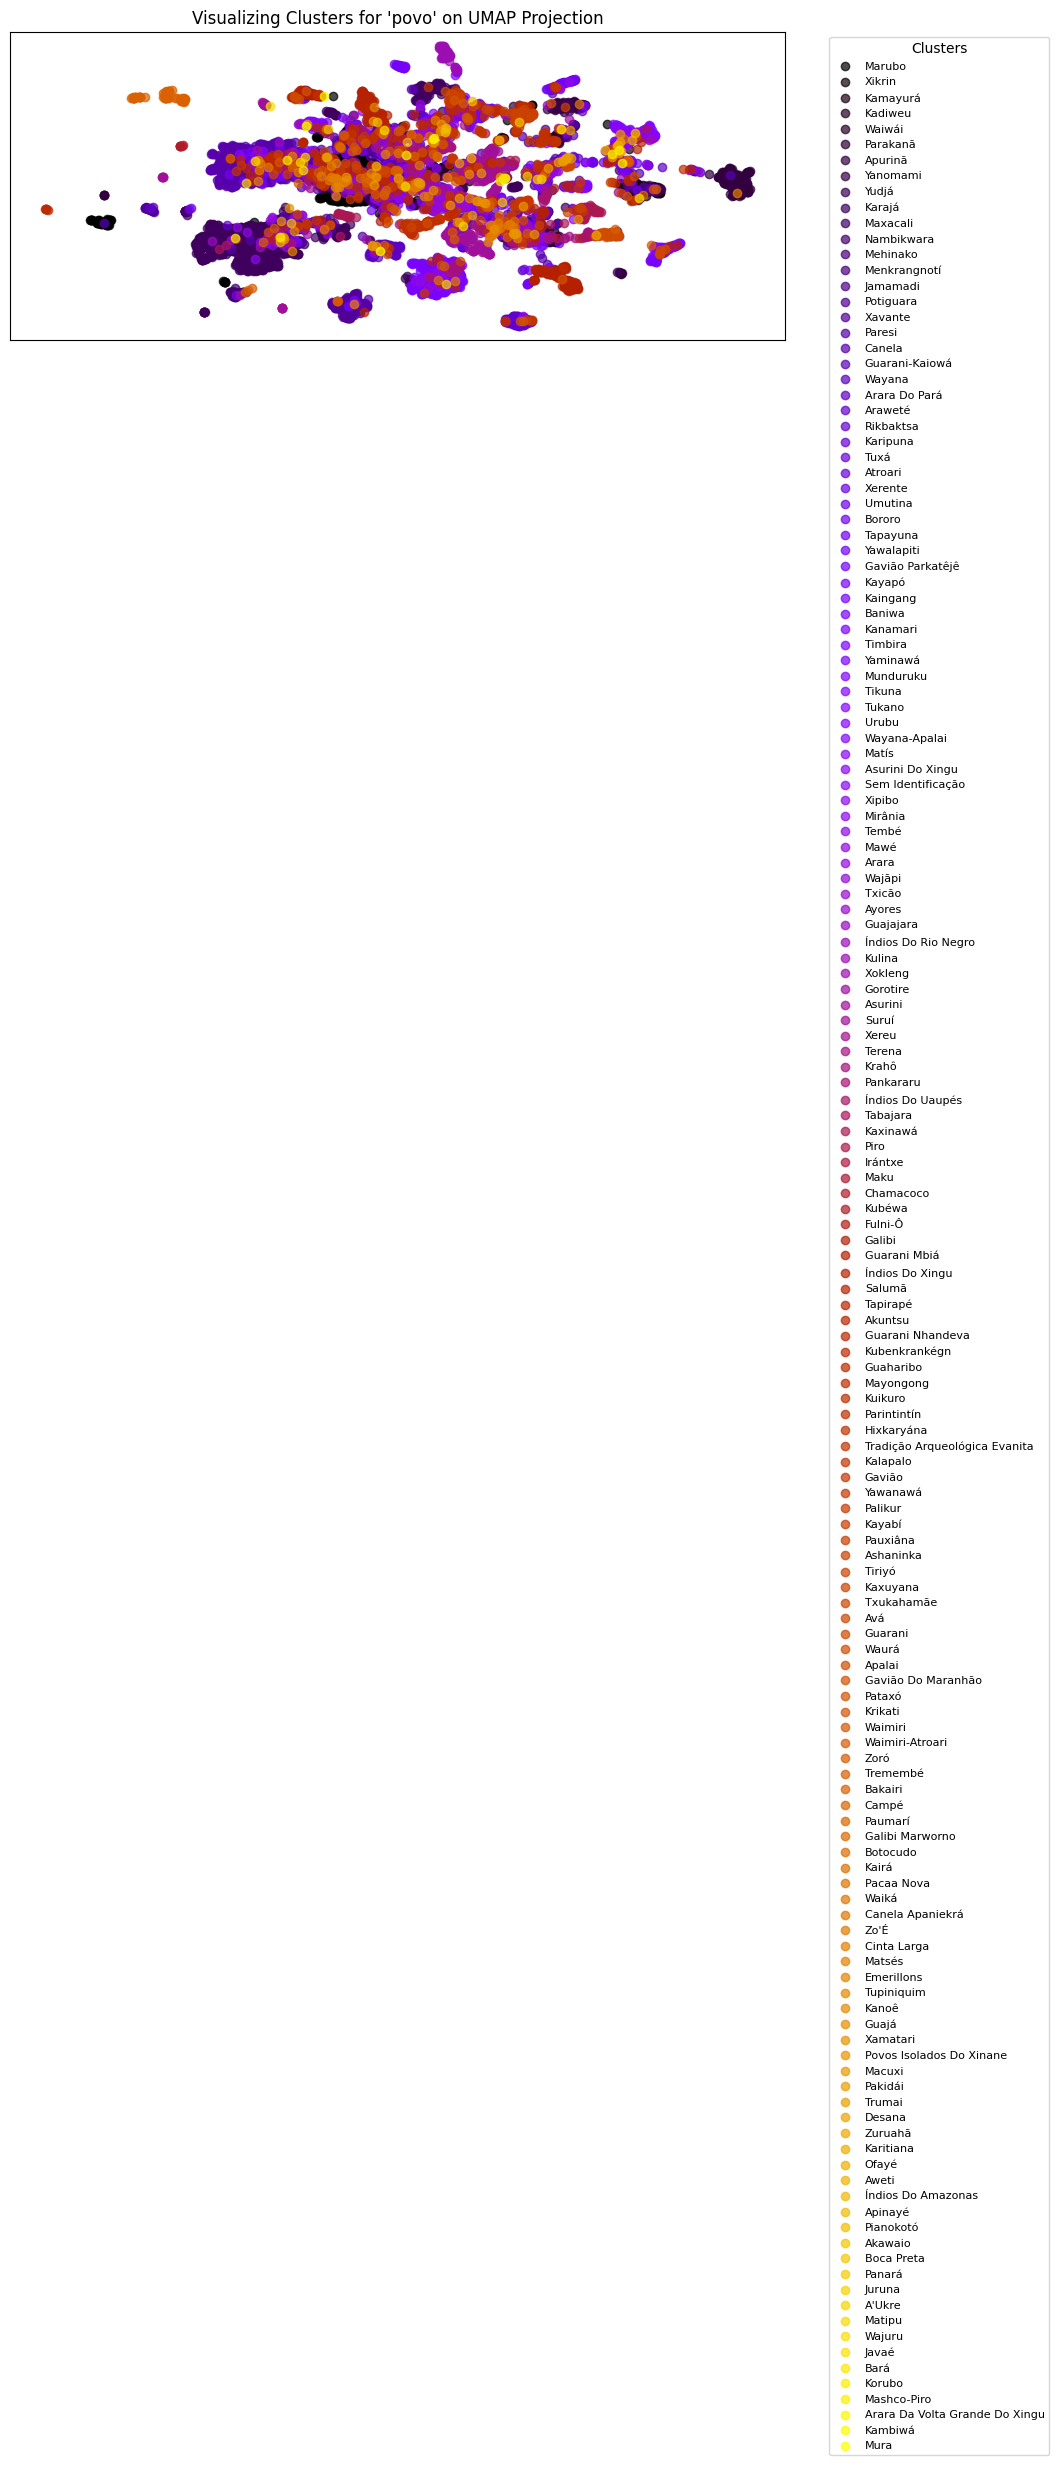

In [29]:
# Filtering dataframe to get only the part that contains images
filtered_df = ind_df.loc[ind_df['image_path'].notna()]

# Visualizing 'povo' cluster
visualizing_clusters(filtered_df, povo_vit_umap, povo_image_indices, 'povo', 'UMAP')

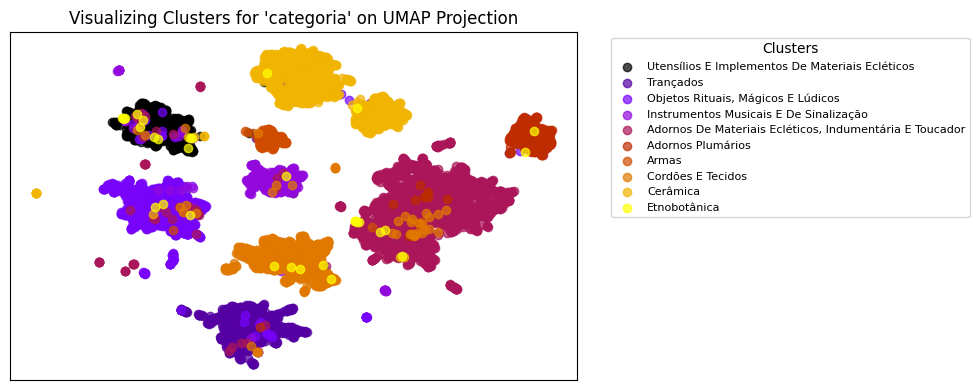

In [30]:
# Visualizing 'categoria' cluster
visualizing_clusters(filtered_df, categoria_vit_umap, categoria_image_indices, \
                     'categoria', 'UMAP')

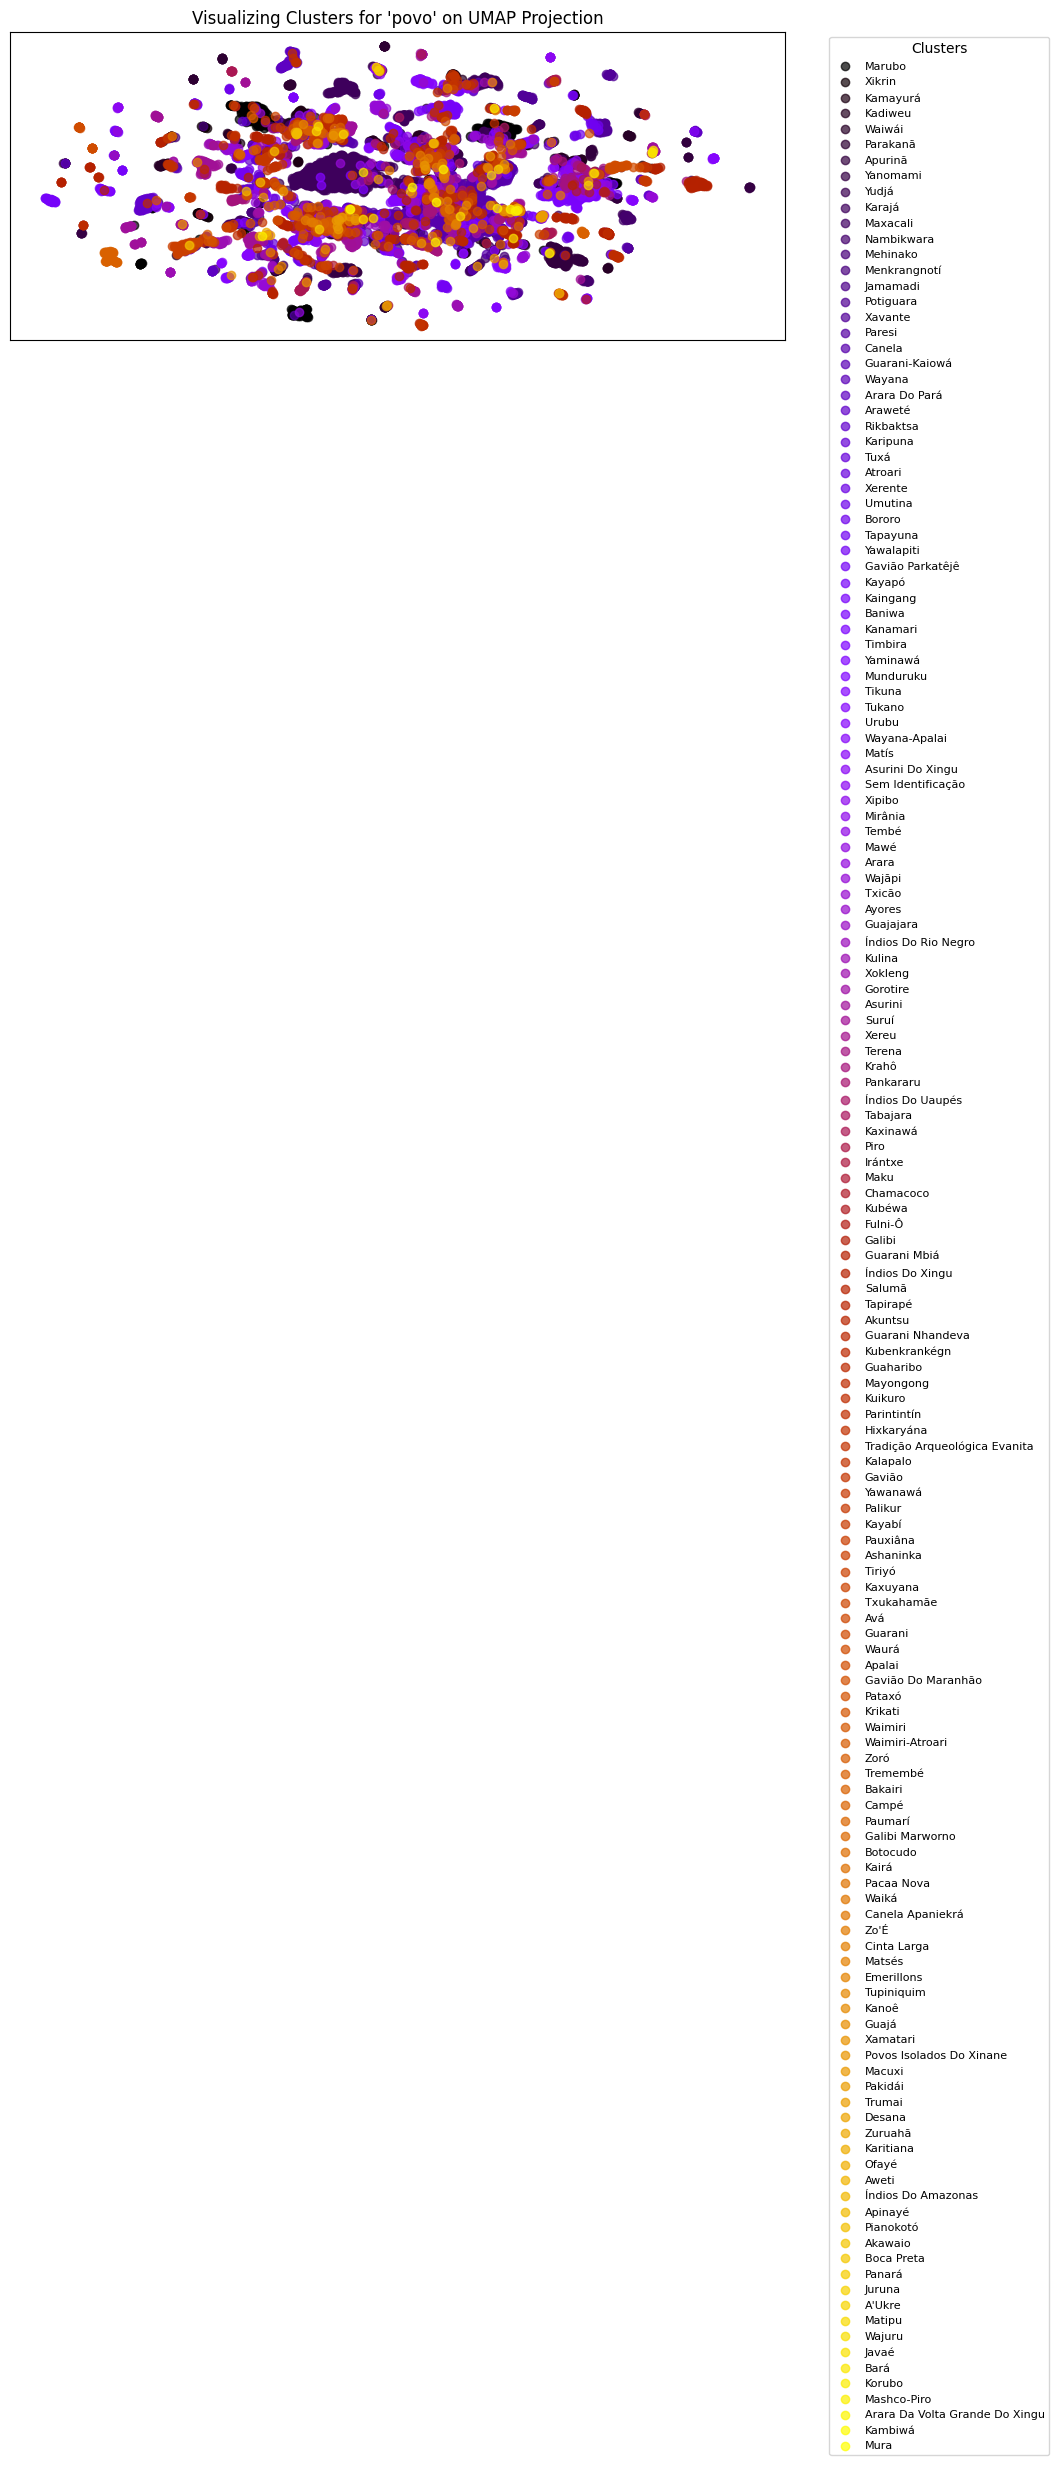

In [31]:
# Visualizing 'povo' cluster for multi-head modedl
visualizing_clusters(filtered_df, multihead_vit_umap, multihead_image_indices, \
                     'povo', 'UMAP')

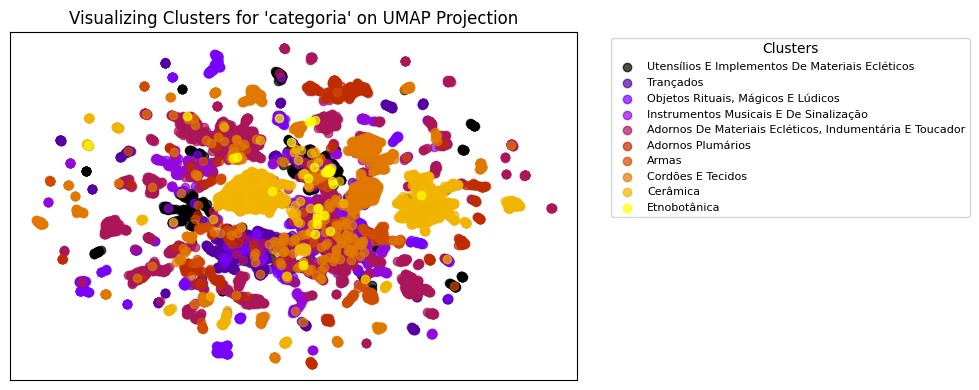

In [32]:
# Visualizing 'categoria' cluster for multi-head modedl
visualizing_clusters(filtered_df, multihead_vit_umap, multihead_image_indices, \
                     'categoria', 'UMAP')

In [33]:
# Saving outputs for visualization tool
_ = saving_outputs(filtered_df, povo_labels, vanilla_vit_umap, vanilla_image_indices, \
                   save_file='vanilla_vit.csv', no_clusters=True)

_ = saving_outputs(filtered_df, povo_labels, povo_vit_umap, povo_image_indices, 'povo', \
                   'povo_vit.csv')

_ = saving_outputs(filtered_df, categoria_labels, categoria_vit_umap, \
                   categoria_image_indices, 'categoria', 'categoria_vit.csv')

_ = saving_outputs(filtered_df, povo_labels, multihead_vit_umap, \
                   multihead_image_indices, save_file='multihead_vit.csv', no_clusters=True)

## DINOv2

### Pre-Trained Embedding Space

In [34]:
from transformers import AutoImageProcessor, AutoModel

# Rebuilding dataset with DINO transform and dataloader with smaller batch_size because of 
# the model's size
dino_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
povo_dataset = ImageDataset(povo_labels, transform=dino_transform, augment=False)
povo_dataloader = DataLoader(povo_dataset, batch_size=16, shuffle=True, \
                             num_workers=0, pin_memory=True)

# Loading model and pre-processor
dino_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')
model.to(device)

# Projecting data onto the off-the-shelf pre-trained embedding space from DINOv2
image_embeddings, vanilla_image_indices = get_embeddings(model, povo_dataloader, device, \
                                                         model_name='dino')
image_embeddings = np.concatenate(image_embeddings, axis=0)
vanilla_image_indices = np.concatenate(vanilla_image_indices, axis=0)

# Computing data reduced-dimensionality projections
_, _, vanilla_dino_umap = data_projections(image_embeddings)

# Cleaning up memory
clean_mem([model, image_embeddings])

Computing embeddings: 100%|███████████████████████████████████████| 705/705 [02:58<00:00,  3.96it/s]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Fine-Tuning Embedding Space

In [35]:
# Creating our own DINO classifier head for fine-tuning
class DINOClassifier(nn.Module):
    def __init__(self, num_classes1, num_classes2=0, freeze=0):
        super(DINOClassifier, self).__init__()
        self.dino = AutoModel.from_pretrained('facebook/dinov2-base')
        self.classifier1 = nn.Linear(self.dino.config.hidden_size, num_classes1)
        self.multi_head = False
        
        # Multi-head architecture
        if num_classes2 > 0:
            self.classifier2 = nn.Linear(self.dino.config.hidden_size, num_classes2)
            self.multi_head = True
        
        self.freeze_layers(freeze)
    
    def forward(self, x):
        outputs = self.dino(x)
        
        # Getting embeddings from last_hidden_state of CLS token (maybe pooler_output?)
        embeddings = outputs['last_hidden_state'][:, 0, :]
        # embeddings = outputs['pooler_output']

        logits1 = self.classifier1(embeddings)
        if self.multi_head:
            logits2 = self.classifier2(embeddings)
            return logits1, logits2
        return logits1

    # Freezing early layers so we don't lose generalization and speed up training
    def freeze_layers(self, freeze):
        if freeze <= 0:
            return

        # Accounting for the embedding freeze
        freeze -= 1
        
        for name, param in self.dino.named_parameters():
            if "embeddings" in name:
                param.requires_grad = False
            elif int(name.split('.')[2]) < freeze:
                param.requires_grad = False
            else:
                break

#### *povo* Column

Training model:   5%|██▎                                          | 1/20 [05:12<1:38:50, 312.15s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1987.0979, Validation Accuracy: 0.3586


Training model:  10%|████▌                                        | 2/20 [10:23<1:33:27, 311.53s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1460.7089, Validation Accuracy: 0.4266


Training model:  15%|██████▊                                      | 3/20 [15:34<1:28:16, 311.58s/it]

Best model saved at epoch 3
Epoch 3, Loss: 1165.6473, Validation Accuracy: 0.4906


Training model:  20%|█████████                                    | 4/20 [20:45<1:23:01, 311.34s/it]

Best model saved at epoch 4
Epoch 4, Loss: 919.2387, Validation Accuracy: 0.5429


Training model:  25%|███████████▎                                 | 5/20 [25:56<1:17:45, 311.06s/it]

Best model saved at epoch 5
Epoch 5, Loss: 700.9535, Validation Accuracy: 0.5488


Training model:  30%|█████████████▌                               | 6/20 [30:59<1:11:55, 308.22s/it]

Best model saved at epoch 6
Epoch 6, Loss: 520.6539, Validation Accuracy: 0.5744


Training model:  35%|███████████████▋                             | 7/20 [36:02<1:06:26, 306.69s/it]

Best model saved at epoch 7
Epoch 7, Loss: 371.3140, Validation Accuracy: 0.5852


Training model:  40%|██████████████████                           | 8/20 [41:05<1:01:04, 305.34s/it]

Epoch 8, Loss: 256.7706, Validation Accuracy: 0.5833


Training model:  45%|█████████████████████▏                         | 9/20 [46:10<55:59, 305.43s/it]

Best model saved at epoch 9
Epoch 9, Loss: 172.2056, Validation Accuracy: 0.5911


Training model:  50%|███████████████████████                       | 10/20 [51:17<50:59, 305.91s/it]

Best model saved at epoch 10
Epoch 10, Loss: 111.7836, Validation Accuracy: 0.5931


Training model:  55%|█████████████████████████▎                    | 11/20 [56:24<45:54, 306.04s/it]

Best model saved at epoch 11
Epoch 11, Loss: 73.4156, Validation Accuracy: 0.6039


Training model:  60%|██████████████████████████▍                 | 12/20 [1:01:29<40:46, 305.79s/it]

Epoch 12, Loss: 48.6458, Validation Accuracy: 0.6020


Training model:  65%|████████████████████████████▌               | 13/20 [1:06:33<35:37, 305.36s/it]

Epoch 13, Loss: 34.3401, Validation Accuracy: 0.5980


Training model:  70%|██████████████████████████████▊             | 14/20 [1:11:39<30:32, 305.42s/it]

Epoch 14, Loss: 24.6031, Validation Accuracy: 0.6030


Training model:  75%|█████████████████████████████████           | 15/20 [1:16:44<25:26, 305.36s/it]

Epoch 15, Loss: 18.7748, Validation Accuracy: 0.6039


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:21:49<20:20, 305.23s/it]

Epoch 16, Loss: 14.9657, Validation Accuracy: 0.5951


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:26:53<15:14, 304.94s/it]

Epoch 17, Loss: 12.0626, Validation Accuracy: 0.5990


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:31:58<10:09, 304.92s/it]

Epoch 18, Loss: 10.0454, Validation Accuracy: 0.6020


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [1:37:03<05:05, 305.08s/it]

Epoch 19, Loss: 10.5035, Validation Accuracy: 0.5961


Training model: 100%|████████████████████████████████████████████| 20/20 [1:42:10<00:00, 306.52s/it]

Best model saved at epoch 20
Epoch 20, Loss: 9.6118, Validation Accuracy: 0.6079


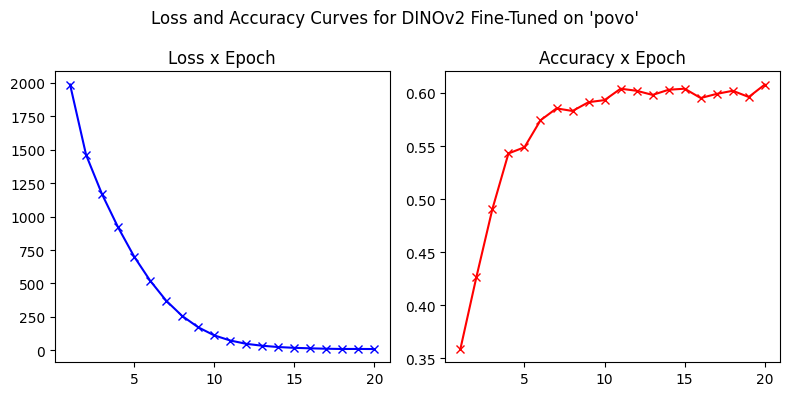

/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Validation accuracy: 0.60791015625
Validation average per class precision: 0.2274
Validation average per class recall: 0.1885

Test accuracy: 0.636202335357666
Test average per class precision: 0.2396
Test average per class recall: 0.2001

Test average precision on filtered classes: 0.53438867131869
Test average recall on filtered classes: 0.5060628606722906


In [36]:
# Recreating datasets for proper training and testing
povo_train_val_dataset = ImageDataset(povo_train_val_labels, transform=dino_transform, \
                                      augment=False)
povo_test_dataset = ImageDataset(povo_test_labels, transform=dino_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 16
epochs = 20
num_classes = ind_df['povo'].dropna().nunique()
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-6, weight_decay=3e-7)
model_name = 'dino_povo'
column_name = 'povo'

test_prec, test_rec = execute_train_test(povo_train_val_dataset, povo_test_dataset, device, \
                                        batch_size, epochs, num_classes, model, criterion, \
                                        opt, model_name, column_name, \
                                        architecture_name='DINOv2')
prec_rec_on_selected_classes(povo_categories, povo_filtered_categories, test_prec, test_rec)

# Cleaning up memory
clean_mem([model])

In [37]:
# Filtering dataframe for selected categories. We need to recompute this part of the dataset
# because of the different transform used
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, povo_augmented_dataset, povo_balanced_val_dataset, \
povo_balanced_test_dataset = filter_image_data_distribution(ind_df, \
                                                            povo_filtered_categories_names, \
                                                            dino_transform, \
                                                            threshold_multiplier, \
                                                            'povo')

Training model:   5%|██▎                                          | 1/20 [08:49<2:47:42, 529.62s/it]

Best model saved at epoch 1
Epoch 1, Loss: 2383.0244, Validation Accuracy: 0.4444


Training model:  10%|████▌                                        | 2/20 [17:32<2:37:40, 525.56s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1369.7241, Validation Accuracy: 0.5399


Training model:  15%|██████▊                                      | 3/20 [26:17<2:28:53, 525.48s/it]

Best model saved at epoch 3
Epoch 3, Loss: 855.8033, Validation Accuracy: 0.6119


Training model:  20%|█████████                                    | 4/20 [35:00<2:19:51, 524.48s/it]

Best model saved at epoch 4
Epoch 4, Loss: 536.6550, Validation Accuracy: 0.6322


Training model:  25%|███████████▎                                 | 5/20 [43:45<2:11:10, 524.67s/it]

Best model saved at epoch 5
Epoch 5, Loss: 340.3065, Validation Accuracy: 0.6573


Training model:  30%|█████████████▌                               | 6/20 [52:23<2:01:52, 522.36s/it]

Best model saved at epoch 6
Epoch 6, Loss: 220.3686, Validation Accuracy: 0.6761


Training model:  35%|███████████████                            | 7/20 [1:01:10<1:53:28, 523.70s/it]

Best model saved at epoch 7
Epoch 7, Loss: 135.6274, Validation Accuracy: 0.6917


Training model:  40%|█████████████████▏                         | 8/20 [1:09:51<1:44:34, 522.88s/it]

Best model saved at epoch 8
Epoch 8, Loss: 91.0373, Validation Accuracy: 0.7011


Training model:  45%|███████████████████▎                       | 9/20 [1:18:36<1:35:59, 523.60s/it]

Best model saved at epoch 9
Epoch 9, Loss: 61.6238, Validation Accuracy: 0.7058


Training model:  50%|█████████████████████                     | 10/20 [1:27:23<1:27:28, 524.85s/it]

Best model saved at epoch 10
Epoch 10, Loss: 42.3458, Validation Accuracy: 0.7074


Training model:  55%|███████████████████████                   | 11/20 [1:36:09<1:18:45, 525.05s/it]

Epoch 11, Loss: 32.2982, Validation Accuracy: 0.6980


Training model:  60%|█████████████████████████▏                | 12/20 [1:44:53<1:09:58, 524.84s/it]

Best model saved at epoch 12
Epoch 12, Loss: 23.4854, Validation Accuracy: 0.7152


Training model:  65%|███████████████████████████▎              | 13/20 [1:53:39<1:01:16, 525.19s/it]

Epoch 13, Loss: 17.0758, Validation Accuracy: 0.7136


Training model:  70%|██████████████████████████████▊             | 14/20 [2:02:15<52:14, 522.41s/it]

Epoch 14, Loss: 12.7393, Validation Accuracy: 0.7089


Training model:  75%|█████████████████████████████████           | 15/20 [2:10:50<43:19, 519.99s/it]

Epoch 15, Loss: 17.9517, Validation Accuracy: 0.6948


Training model:  80%|███████████████████████████████████▏        | 16/20 [2:19:24<34:33, 518.29s/it]

Best model saved at epoch 16
Epoch 16, Loss: 10.2048, Validation Accuracy: 0.7277


Training model:  85%|█████████████████████████████████████▍      | 17/20 [2:28:13<26:04, 521.63s/it]

Epoch 17, Loss: 16.0424, Validation Accuracy: 0.7136


Training model:  90%|███████████████████████████████████████▌    | 18/20 [2:36:56<17:23, 521.99s/it]

Epoch 18, Loss: 6.8551, Validation Accuracy: 0.7230


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [2:45:33<08:40, 520.29s/it]

Epoch 19, Loss: 5.0718, Validation Accuracy: 0.6980


Training model: 100%|████████████████████████████████████████████| 20/20 [2:54:08<00:00, 522.45s/it]


Epoch 20, Loss: 6.3040, Validation Accuracy: 0.7183


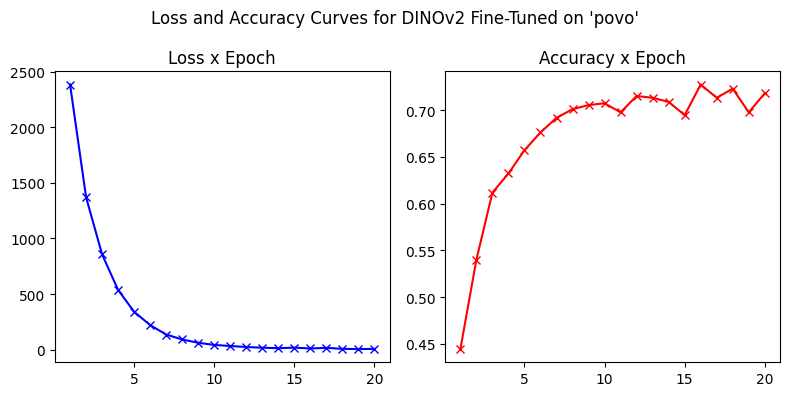

Validation accuracy: 0.7275390625
Validation average per class precision: 0.7190
Validation average per class recall: 0.7104



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test accuracy: 0.7195122241973877
Test average per class precision: 0.7114
Test average per class recall: 0.6824



In [38]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 20
num_classes = len(povo_filtered_categories)
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=1e-6, weight_decay=3e-7)
model_name = 'balanced_dino_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset, architecture_name='DINOv2')

# _, _, \
# povo_dino_umap, povo_image_indices = compute_classifier_embeddings(povo_dataloader, model, \
#                                                                    device, 'dino')

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [06:16<1:59:05, 376.08s/it]

Best model saved at epoch 1
Epoch 1, Loss: 2563.2398, Validation Accuracy: 0.3693


Training model:  10%|████▌                                        | 2/20 [12:30<1:52:29, 374.95s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1641.3781, Validation Accuracy: 0.5055


Training model:  15%|██████▊                                      | 3/20 [18:40<1:45:35, 372.70s/it]

Best model saved at epoch 3
Epoch 3, Loss: 1176.0690, Validation Accuracy: 0.5634


Training model:  20%|█████████                                    | 4/20 [24:53<1:39:25, 372.86s/it]

Best model saved at epoch 4
Epoch 4, Loss: 865.6414, Validation Accuracy: 0.5884


Training model:  25%|███████████▎                                 | 5/20 [31:04<1:33:02, 372.15s/it]

Best model saved at epoch 5
Epoch 5, Loss: 641.5674, Validation Accuracy: 0.6275


Training model:  30%|█████████████▌                               | 6/20 [37:09<1:26:17, 369.84s/it]

Best model saved at epoch 6
Epoch 6, Loss: 476.2085, Validation Accuracy: 0.6354


Training model:  35%|███████████████▋                             | 7/20 [43:13<1:19:44, 368.02s/it]

Best model saved at epoch 7
Epoch 7, Loss: 358.5075, Validation Accuracy: 0.6541


Training model:  40%|██████████████████                           | 8/20 [49:15<1:13:13, 366.10s/it]

Best model saved at epoch 8
Epoch 8, Loss: 264.9935, Validation Accuracy: 0.6761


Training model:  45%|████████████████████▎                        | 9/20 [55:20<1:07:02, 365.67s/it]

Epoch 9, Loss: 197.2847, Validation Accuracy: 0.6682


Training model:  50%|█████████████████████                     | 10/20 [1:01:26<1:00:58, 365.88s/it]

Best model saved at epoch 10
Epoch 10, Loss: 144.2145, Validation Accuracy: 0.6776


Training model:  55%|████████████████████████▏                   | 11/20 [1:07:41<55:17, 368.66s/it]

Best model saved at epoch 11
Epoch 11, Loss: 106.5552, Validation Accuracy: 0.6854


Training model:  60%|██████████████████████████▍                 | 12/20 [1:13:52<49:12, 369.12s/it]

Best model saved at epoch 12
Epoch 12, Loss: 78.6871, Validation Accuracy: 0.6901


Training model:  65%|████████████████████████████▌               | 13/20 [1:19:53<42:48, 366.91s/it]

Best model saved at epoch 13
Epoch 13, Loss: 58.9908, Validation Accuracy: 0.6964


Training model:  70%|██████████████████████████████▊             | 14/20 [1:26:02<36:44, 367.37s/it]

Epoch 14, Loss: 41.8949, Validation Accuracy: 0.6933


Training model:  75%|█████████████████████████████████           | 15/20 [1:32:15<30:44, 368.99s/it]

Best model saved at epoch 15
Epoch 15, Loss: 32.2432, Validation Accuracy: 0.6995


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:38:31<24:45, 371.29s/it]

Best model saved at epoch 16
Epoch 16, Loss: 23.8034, Validation Accuracy: 0.7074


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:44:33<18:25, 368.37s/it]

Epoch 17, Loss: 19.2453, Validation Accuracy: 0.7027


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:50:36<12:13, 366.69s/it]

Best model saved at epoch 18
Epoch 18, Loss: 14.1270, Validation Accuracy: 0.7121


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [1:56:37<06:05, 365.05s/it]

Epoch 19, Loss: 10.7887, Validation Accuracy: 0.7089


Training model: 100%|████████████████████████████████████████████| 20/20 [2:02:40<00:00, 368.00s/it]


Epoch 20, Loss: 9.2372, Validation Accuracy: 0.7121


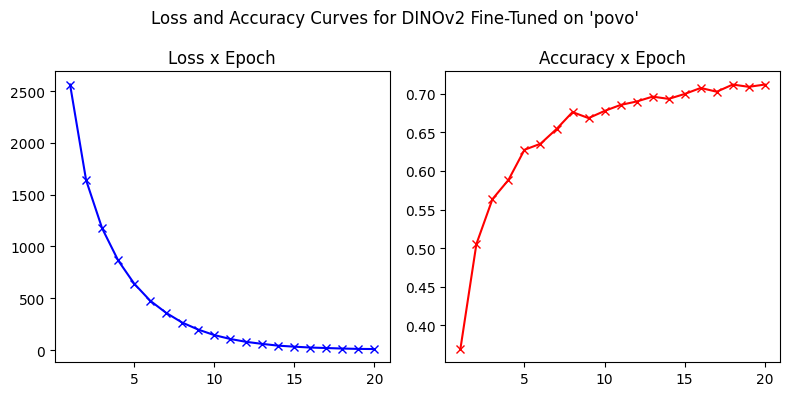

Validation accuracy: 0.7119140625
Validation average per class precision: 0.7178
Validation average per class recall: 0.6983

Test accuracy: 0.7386759519577026
Test average per class precision: 0.7566
Test average per class recall: 0.6949



Computing embeddings: 100%|███████████████████████████████████████| 705/705 [03:02<00:00,  3.86it/s]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [39]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 20
num_classes = len(povo_filtered_categories)
freeze = 9
model = DINOClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=1e-6, weight_decay=3e-7)
model_name = 'frozen_dino_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, povo_balanced_val_dataset, architecture_name='DINOv2')

_, _, \
povo_dino_umap, povo_image_indices = compute_classifier_embeddings(povo_dataloader, model, \
                                                                   device, 'dino')

# Cleaning up memory
clean_mem([model])

#### *categoria* Column

Training model:   5%|██▎                                          | 1/20 [05:04<1:36:29, 304.74s/it]

Best model saved at epoch 1
Epoch 1, Loss: 786.5767, Validation Accuracy: 0.6837


Training model:  10%|████▌                                        | 2/20 [10:17<1:32:49, 309.44s/it]

Best model saved at epoch 2
Epoch 2, Loss: 443.8506, Validation Accuracy: 0.7537


Training model:  15%|██████▊                                      | 3/20 [15:28<1:27:49, 309.96s/it]

Best model saved at epoch 3
Epoch 3, Loss: 333.1492, Validation Accuracy: 0.8039


Training model:  20%|█████████                                    | 4/20 [20:41<1:22:59, 311.21s/it]

Best model saved at epoch 4
Epoch 4, Loss: 260.5758, Validation Accuracy: 0.8325


Training model:  25%|███████████▎                                 | 5/20 [25:51<1:17:45, 311.01s/it]

Best model saved at epoch 5
Epoch 5, Loss: 206.2549, Validation Accuracy: 0.8473


Training model:  30%|█████████████▌                               | 6/20 [31:03<1:12:34, 311.07s/it]

Best model saved at epoch 6
Epoch 6, Loss: 162.2822, Validation Accuracy: 0.8581


Training model:  35%|███████████████▋                             | 7/20 [36:13<1:07:21, 310.90s/it]

Epoch 7, Loss: 127.2216, Validation Accuracy: 0.8542


Training model:  40%|██████████████████                           | 8/20 [41:22<1:02:04, 310.35s/it]

Best model saved at epoch 8
Epoch 8, Loss: 96.9040, Validation Accuracy: 0.8631


Training model:  45%|█████████████████████▏                         | 9/20 [46:28<56:36, 308.77s/it]

Best model saved at epoch 9
Epoch 9, Loss: 73.0292, Validation Accuracy: 0.8719


Training model:  50%|███████████████████████                       | 10/20 [51:33<51:17, 307.74s/it]

Best model saved at epoch 10
Epoch 10, Loss: 53.7148, Validation Accuracy: 0.8788


Training model:  55%|█████████████████████████▎                    | 11/20 [56:40<46:06, 307.40s/it]

Epoch 11, Loss: 39.1972, Validation Accuracy: 0.8729


Training model:  60%|██████████████████████████▍                 | 12/20 [1:01:44<40:52, 306.61s/it]

Epoch 12, Loss: 28.7022, Validation Accuracy: 0.8680


Training model:  65%|████████████████████████████▌               | 13/20 [1:06:49<35:40, 305.85s/it]

Epoch 13, Loss: 21.3675, Validation Accuracy: 0.8690


Training model:  70%|██████████████████████████████▊             | 14/20 [1:11:53<30:31, 305.32s/it]

Epoch 14, Loss: 15.7047, Validation Accuracy: 0.8719


Training model:  75%|█████████████████████████████████           | 15/20 [1:16:56<25:23, 304.75s/it]

Epoch 15, Loss: 11.9806, Validation Accuracy: 0.8778


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:21:59<20:17, 304.27s/it]

Epoch 16, Loss: 9.8504, Validation Accuracy: 0.8788


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:27:04<15:13, 304.42s/it]

Epoch 17, Loss: 7.2756, Validation Accuracy: 0.8788


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:32:08<10:08, 304.41s/it]

Best model saved at epoch 18
Epoch 18, Loss: 6.2904, Validation Accuracy: 0.8818


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [1:37:11<05:03, 303.89s/it]

Epoch 19, Loss: 5.0489, Validation Accuracy: 0.8759


Training model: 100%|████████████████████████████████████████████| 20/20 [1:42:15<00:00, 306.75s/it]

Epoch 20, Loss: 4.4384, Validation Accuracy: 0.8729


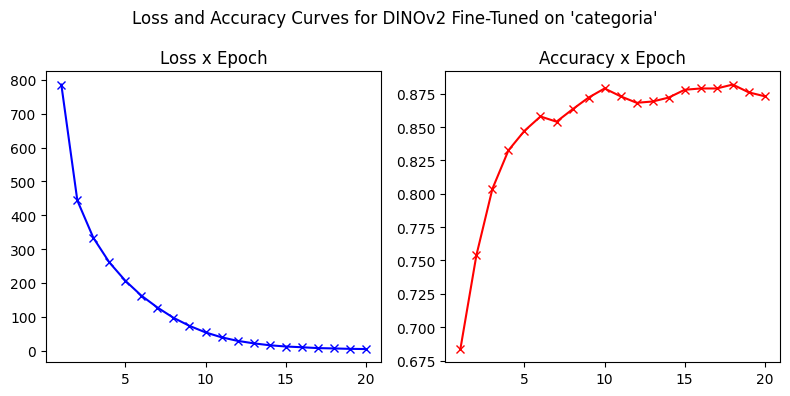

/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Validation accuracy: 0.8818359375
Validation average per class precision: 0.8765
Validation average per class recall: 0.7915

Test accuracy: 0.8757764101028442
Test average per class precision: 0.8777
Test average per class recall: 0.8301

Test average precision on filtered classes: 0.8640568852424622
Test average recall on filtered classes: 0.8482607271936204


In [40]:
# Now creating the 'categoria' dataset
categoria_dataset = ImageDataset(categoria_labels, transform=dino_transform)
categoria_dataloader = DataLoader(categoria_dataset, batch_size=8, shuffle=True, \
                                  num_workers=0, pin_memory=True)

# Recreating datasets for proper training and testing
categoria_train_val_dataset = ImageDataset(categoria_train_val_labels, \
                                           transform=dino_transform, augment=False)
categoria_test_dataset = ImageDataset(categoria_test_labels, transform=dino_transform, \
                                      augment=False)

# Setting-up training, executing training and then running tests
batch_size = 16
epochs = 20
num_classes = ind_df['categoria'].dropna().nunique()
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=3e-7, weight_decay=1e-7)
model_name = 'dino_categoria'
column_name = 'categoria'

test_prec, test_rec = execute_train_test(categoria_train_val_dataset, categoria_test_dataset, \
                                         device, batch_size, epochs, num_classes, model, \
                                         criterion, opt, model_name, column_name, \
                                         architecture_name='DINOv2')
prec_rec_on_selected_classes(categoria_categories, categoria_filtered_categories, test_prec, \
                             test_rec)

# Cleaning up memory
clean_mem([model])

In [41]:
# Filtering dataframe for selected categories. We need to recompute this part of the dataset
# because of the different transform used
threshold_multiplier = 1.5
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, categoria_augmented_dataset, categoria_balanced_val_dataset, \
categoria_balanced_test_dataset = \
filter_image_data_distribution(ind_df, categoria_filtered_categories_names, dino_transform, \
                               threshold_multiplier, 'categoria')

Training model:   5%|██▎                                          | 1/20 [14:11<4:29:32, 851.16s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1692.1068, Validation Accuracy: 0.7663


Training model:  10%|████▌                                        | 2/20 [28:19<4:14:47, 849.31s/it]

Best model saved at epoch 2
Epoch 2, Loss: 841.8765, Validation Accuracy: 0.8224


Training model:  15%|██████▊                                      | 3/20 [42:28<4:00:40, 849.42s/it]

Best model saved at epoch 3
Epoch 3, Loss: 562.3617, Validation Accuracy: 0.8519


Training model:  20%|█████████                                    | 4/20 [56:35<3:46:12, 848.29s/it]

Best model saved at epoch 4
Epoch 4, Loss: 394.4673, Validation Accuracy: 0.8740


Training model:  25%|██████████▊                                | 5/20 [1:10:43<3:32:06, 848.44s/it]

Best model saved at epoch 5
Epoch 5, Loss: 277.5741, Validation Accuracy: 0.8758


Training model:  30%|████████████▉                              | 6/20 [1:24:53<3:18:03, 848.82s/it]

Best model saved at epoch 6
Epoch 6, Loss: 191.9507, Validation Accuracy: 0.8859


Training model:  35%|███████████████                            | 7/20 [1:39:00<3:03:45, 848.09s/it]

Best model saved at epoch 7
Epoch 7, Loss: 137.2336, Validation Accuracy: 0.8960


Training model:  40%|█████████████████▏                         | 8/20 [1:53:12<2:49:54, 849.58s/it]

Epoch 8, Loss: 96.1487, Validation Accuracy: 0.8951


Training model:  45%|███████████████████▎                       | 9/20 [2:07:22<2:35:46, 849.67s/it]

Epoch 9, Loss: 70.5349, Validation Accuracy: 0.8905


Training model:  50%|█████████████████████                     | 10/20 [2:21:20<2:21:01, 846.12s/it]

Best model saved at epoch 10
Epoch 10, Loss: 51.3228, Validation Accuracy: 0.9034


Training model:  55%|███████████████████████                   | 11/20 [2:35:30<2:07:05, 847.23s/it]

Epoch 11, Loss: 38.6784, Validation Accuracy: 0.8979


Training model:  60%|█████████████████████████▏                | 12/20 [2:49:40<1:53:03, 847.90s/it]

Epoch 12, Loss: 30.8410, Validation Accuracy: 0.9016


Training model:  65%|███████████████████████████▎              | 13/20 [3:03:43<1:38:46, 846.62s/it]

Epoch 13, Loss: 24.6999, Validation Accuracy: 0.8979


Training model:  70%|█████████████████████████████▍            | 14/20 [3:17:53<1:24:44, 847.45s/it]

Best model saved at epoch 14
Epoch 14, Loss: 18.8581, Validation Accuracy: 0.9071


Training model:  75%|███████████████████████████████▌          | 15/20 [3:32:01<1:10:39, 847.82s/it]

Epoch 15, Loss: 18.6764, Validation Accuracy: 0.9071


Training model:  80%|███████████████████████████████████▏        | 16/20 [3:46:09<56:30, 847.65s/it]

Epoch 16, Loss: 12.6633, Validation Accuracy: 0.9043


Training model:  85%|█████████████████████████████████████▍      | 17/20 [4:00:13<42:20, 846.69s/it]

Epoch 17, Loss: 14.5484, Validation Accuracy: 0.8997


Training model:  90%|███████████████████████████████████████▌    | 18/20 [4:14:20<28:13, 846.84s/it]

Best model saved at epoch 18
Epoch 18, Loss: 11.5238, Validation Accuracy: 0.9098


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [4:28:28<14:07, 847.25s/it]

Epoch 19, Loss: 8.7877, Validation Accuracy: 0.9043


Training model: 100%|████████████████████████████████████████████| 20/20 [4:42:36<00:00, 847.80s/it]


Epoch 20, Loss: 11.5337, Validation Accuracy: 0.9098


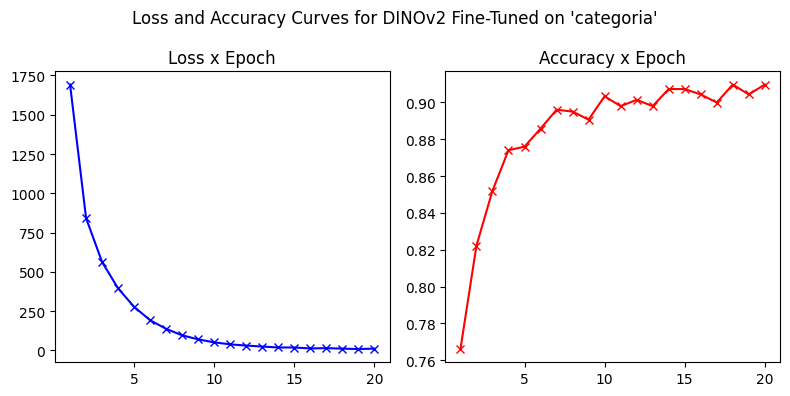

Validation accuracy: 0.90966796875
Validation average per class precision: 0.8871
Validation average per class recall: 0.8840



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test accuracy: 0.8936605453491211
Test average per class precision: 0.8625
Test average per class recall: 0.8492



In [42]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=3e-7, weight_decay=1e-7)
model_name = 'balanced_dino_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset, architecture_name='DINOv2')

# _, _, \
# categoria_dino_umap, categoria_image_indices = \
# compute_classifier_embeddings(categoria_dataloader, model, device, 'dino')

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [10:59<3:28:54, 659.71s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1782.5082, Validation Accuracy: 0.7452


Training model:  10%|████▌                                        | 2/20 [22:03<3:18:35, 661.96s/it]

Best model saved at epoch 2
Epoch 2, Loss: 922.1164, Validation Accuracy: 0.7930


Training model:  15%|██████▊                                      | 3/20 [33:07<3:07:54, 663.23s/it]

Best model saved at epoch 3
Epoch 3, Loss: 671.6996, Validation Accuracy: 0.8289


Training model:  20%|█████████                                    | 4/20 [44:10<2:56:48, 663.03s/it]

Best model saved at epoch 4
Epoch 4, Loss: 520.6299, Validation Accuracy: 0.8408


Training model:  25%|███████████▎                                 | 5/20 [55:10<2:45:30, 662.04s/it]

Best model saved at epoch 5
Epoch 5, Loss: 401.6107, Validation Accuracy: 0.8537


Training model:  30%|████████████▉                              | 6/20 [1:06:16<2:34:42, 663.06s/it]

Best model saved at epoch 6
Epoch 6, Loss: 311.0676, Validation Accuracy: 0.8638


Training model:  35%|███████████████                            | 7/20 [1:17:13<2:23:16, 661.26s/it]

Best model saved at epoch 7
Epoch 7, Loss: 237.7090, Validation Accuracy: 0.8703


Training model:  40%|█████████████████▏                         | 8/20 [1:28:13<2:12:08, 660.73s/it]

Best model saved at epoch 8
Epoch 8, Loss: 183.1634, Validation Accuracy: 0.8786


Training model:  45%|███████████████████▎                       | 9/20 [1:39:18<2:01:22, 662.09s/it]

Best model saved at epoch 9
Epoch 9, Loss: 141.0020, Validation Accuracy: 0.8822


Training model:  50%|█████████████████████                     | 10/20 [1:50:19<1:50:19, 661.97s/it]

Epoch 10, Loss: 109.7454, Validation Accuracy: 0.8795


Training model:  55%|███████████████████████                   | 11/20 [2:01:19<1:39:10, 661.14s/it]

Best model saved at epoch 11
Epoch 11, Loss: 82.4597, Validation Accuracy: 0.8960


Training model:  60%|█████████████████████████▏                | 12/20 [2:12:19<1:28:07, 660.88s/it]

Epoch 12, Loss: 64.4653, Validation Accuracy: 0.8951


Training model:  65%|███████████████████████████▎              | 13/20 [2:23:21<1:17:08, 661.15s/it]

Epoch 13, Loss: 51.0764, Validation Accuracy: 0.8896


Training model:  70%|█████████████████████████████▍            | 14/20 [2:34:24<1:06:10, 661.82s/it]

Epoch 14, Loss: 39.1813, Validation Accuracy: 0.8960


Training model:  75%|█████████████████████████████████           | 15/20 [2:45:25<55:08, 661.61s/it]

Epoch 15, Loss: 30.1655, Validation Accuracy: 0.8942


Training model:  80%|███████████████████████████████████▏        | 16/20 [2:56:22<44:01, 660.27s/it]

Epoch 16, Loss: 24.5672, Validation Accuracy: 0.8960


Training model:  85%|█████████████████████████████████████▍      | 17/20 [3:07:26<33:03, 661.33s/it]

Best model saved at epoch 17
Epoch 17, Loss: 20.6218, Validation Accuracy: 0.9006


Training model:  90%|███████████████████████████████████████▌    | 18/20 [3:18:32<22:05, 662.69s/it]

Best model saved at epoch 18
Epoch 18, Loss: 17.5859, Validation Accuracy: 0.9025


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [3:29:31<11:01, 661.41s/it]

Best model saved at epoch 19
Epoch 19, Loss: 15.0053, Validation Accuracy: 0.9071


Training model: 100%|████████████████████████████████████████████| 20/20 [3:40:30<00:00, 661.54s/it]


Epoch 20, Loss: 12.3392, Validation Accuracy: 0.8997


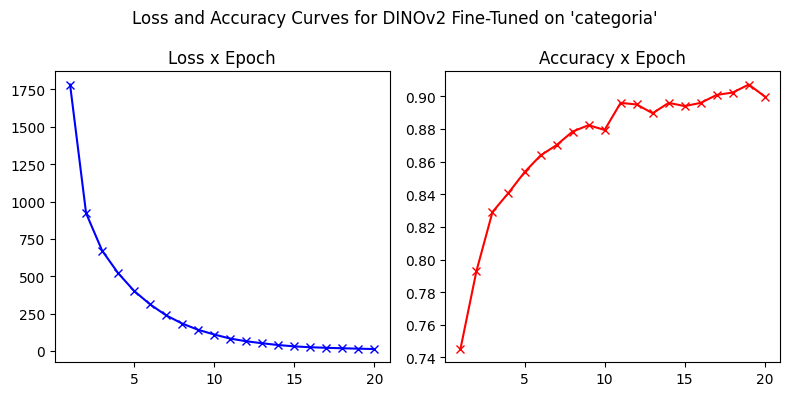

Validation accuracy: 0.9072265625
Validation average per class precision: 0.8853
Validation average per class recall: 0.8927

Test accuracy: 0.8977504968643188
Test average per class precision: 0.8621
Test average per class recall: 0.8613



Computing embeddings: 100%|█████████████████████████████████████| 1410/1410 [02:59<00:00,  7.84it/s]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [43]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
freeze = 7
model = DINOClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=3e-7, weight_decay=1e-7)
model_name = 'frozen_dino_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset, architecture_name='DINOv2')

_, _, \
categoria_dino_umap, categoria_image_indices = \
compute_classifier_embeddings(categoria_dataloader, model, device, 'dino')

# Cleaning up memory
clean_mem([model])

#### Multi-Head Training

In [44]:
# Filtering dataframe for selected categories
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, multi_augmented_dataset, multi_balanced_val_dataset, \
multi_balanced_test_dataset = \
multihead_filter_image_data_distribution(ind_df, [multi_povo_filtered_categories_names, \
                                         multi_categoria_filtered_categories_names], \
                                         dino_transform, threshold_multiplier, \
                                         ['povo', 'categoria'])

In [45]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
multi_povo_class_weights = multihead_compute_class_weights(multi_povo_filtered_categories, \
                                                           labels_minority, labels_majority, \
                                                           device, threshold_multiplier, \
                                                           'povo')

multi_categoria_class_weights = \
multihead_compute_class_weights(multi_categoria_filtered_categories, labels_minority, \
                                labels_majority, device, threshold_multiplier,'categoria')

Training model:   5%|██▎                                          | 1/20 [08:44<2:46:07, 524.59s/it]

Best model saved at epoch 1
Epoch 1, Combined Loss: 4119.1751, Validation Average Accuracy: 0.4873


Training model:  10%|████▌                                        | 2/20 [17:31<2:37:42, 525.70s/it]

Best model saved at epoch 2
Epoch 2, Combined Loss: 2843.6138, Validation Average Accuracy: 0.5923


Training model:  15%|██████▊                                      | 3/20 [26:12<2:28:24, 523.81s/it]

Best model saved at epoch 3
Epoch 3, Combined Loss: 2252.3810, Validation Average Accuracy: 0.6318


Training model:  20%|█████████                                    | 4/20 [34:48<2:18:50, 520.63s/it]

Best model saved at epoch 4
Epoch 4, Combined Loss: 1838.2685, Validation Average Accuracy: 0.6797


Training model:  25%|███████████▎                                 | 5/20 [43:17<2:09:07, 516.48s/it]

Best model saved at epoch 5
Epoch 5, Combined Loss: 1506.7011, Validation Average Accuracy: 0.7109


Training model:  30%|█████████████▌                               | 6/20 [51:57<2:00:48, 517.78s/it]

Best model saved at epoch 6
Epoch 6, Combined Loss: 1255.2117, Validation Average Accuracy: 0.7227


Training model:  35%|███████████████                            | 7/20 [1:00:39<1:52:29, 519.16s/it]

Best model saved at epoch 7
Epoch 7, Combined Loss: 1045.0322, Validation Average Accuracy: 0.7334


Training model:  40%|█████████████████▏                         | 8/20 [1:09:24<1:44:12, 521.07s/it]

Best model saved at epoch 8
Epoch 8, Combined Loss: 867.8190, Validation Average Accuracy: 0.7441


Training model:  45%|███████████████████▎                       | 9/20 [1:18:05<1:35:31, 521.02s/it]

Best model saved at epoch 9
Epoch 9, Combined Loss: 716.7639, Validation Average Accuracy: 0.7529


Training model:  50%|█████████████████████                     | 10/20 [1:26:51<1:27:04, 522.42s/it]

Epoch 10, Combined Loss: 599.2819, Validation Average Accuracy: 0.7529


Training model:  55%|███████████████████████                   | 11/20 [1:35:35<1:18:25, 522.82s/it]

Epoch 11, Combined Loss: 496.0849, Validation Average Accuracy: 0.7500


Training model:  60%|█████████████████████████▏                | 12/20 [1:44:07<1:09:16, 519.52s/it]

Best model saved at epoch 12
Epoch 12, Combined Loss: 409.5560, Validation Average Accuracy: 0.7603


Training model:  65%|███████████████████████████▎              | 13/20 [1:52:48<1:00:40, 520.11s/it]

Best model saved at epoch 13
Epoch 13, Combined Loss: 341.7762, Validation Average Accuracy: 0.7681


Training model:  70%|██████████████████████████████▊             | 14/20 [2:01:32<52:07, 521.31s/it]

Epoch 14, Combined Loss: 280.6790, Validation Average Accuracy: 0.7642


Training model:  75%|█████████████████████████████████           | 15/20 [2:10:13<43:25, 521.03s/it]

Best model saved at epoch 15
Epoch 15, Combined Loss: 230.1401, Validation Average Accuracy: 0.7773


Training model:  80%|███████████████████████████████████▏        | 16/20 [2:18:56<34:47, 521.84s/it]

Best model saved at epoch 16
Epoch 16, Combined Loss: 191.0072, Validation Average Accuracy: 0.7812


Training model:  85%|█████████████████████████████████████▍      | 17/20 [2:27:37<26:04, 521.63s/it]

Best model saved at epoch 17
Epoch 17, Combined Loss: 156.9591, Validation Average Accuracy: 0.7822


Training model:  90%|███████████████████████████████████████▌    | 18/20 [2:36:13<17:19, 519.86s/it]

Best model saved at epoch 18
Epoch 18, Combined Loss: 130.5893, Validation Average Accuracy: 0.7871


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [2:44:51<08:39, 519.21s/it]

Epoch 19, Combined Loss: 108.4799, Validation Average Accuracy: 0.7812


Training model: 100%|████████████████████████████████████████████| 20/20 [2:53:19<00:00, 519.99s/it]


Best model saved at epoch 20
Epoch 20, Combined Loss: 89.1522, Validation Average Accuracy: 0.7925


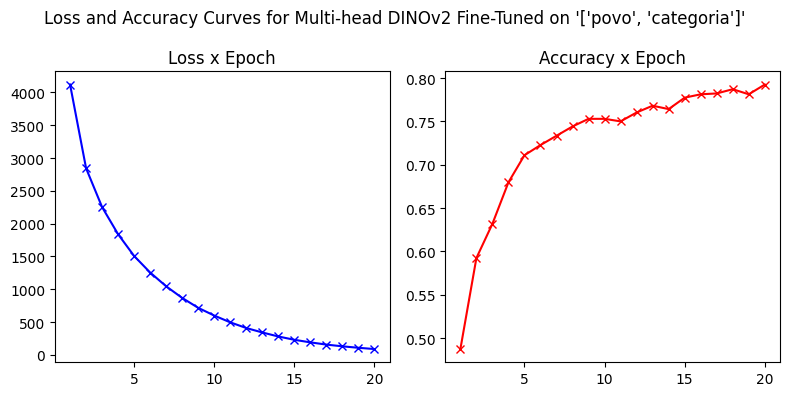

Validation 'povo' head accuracy: 0.7080078125
Validation 'categoria' head accuracy: 0.876953125
Validation average accuracy: 0.79248046875

Validation 'povo' head average per class precision: 0.7043
Validation 'povo' head average per class recall: 0.6739

Validation 'categoria' head average per class precision: 0.8706
Validation 'categoria' head average per class recall: 0.8187



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:719: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test 'povo' head accuracy: 0.6830122470855713
Test 'categoria' head accuracy: 0.900175154209137
Test average accuracy: 0.79150390625

Test 'povo' head average per class precision: 0.6706
Test 'povo' head average per class recall: 0.6337

Test 'categoria' head average per class precision: 0.8735
Test 'categoria' head average per class recall: 0.8833



Computing embeddings: 100%|█████████████████████████████████████| 1410/1410 [02:58<00:00,  7.89it/s]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [46]:
import image_training_utils
importlib.reload(image_training_utils)
from image_training_utils import *

# Training multi-head model on balanced dataset to see the difference in results
batch_size = 8
epochs = 20
num_classes = [len(multi_povo_filtered_categories), len(multi_categoria_filtered_categories)]
model = DINOClassifier(num_classes[0], num_classes[1]).to(device)
criterions = [nn.CrossEntropyLoss(weight=multi_povo_class_weights), \
              nn.CrossEntropyLoss(weight=multi_categoria_class_weights)]
opt = optim.Adam(model.parameters(), lr=3e-7, weight_decay=1e-7)
model_name = 'multihead_dino'
column_names = ['povo', 'categoria']
arch_name = 'DINOv2'
head_weights = [0.5, 0.5]

multihead_execute_train_test(multi_augmented_dataset, multi_balanced_test_dataset, device, \
                             batch_size, epochs, num_classes, model, \
                             criterions, opt, model_name, column_names, \
                             multi_balanced_val_dataset, arch_name, head_weights)

_, _, multihead_dino_umap, \
multihead_image_indices = compute_classifier_embeddings(categoria_dataloader, model, device, \
                                                        'dino')

# Cleaning up memory
clean_mem([model])

### Visualizing and Comparing Projections

In [47]:
# Normalizing data for later plot on tool
vanilla_dino_umap = normalize(vanilla_dino_umap, norm_factor)
povo_dino_umap = normalize(povo_dino_umap, norm_factor)
categoria_dino_umap = normalize(categoria_dino_umap, norm_factor)

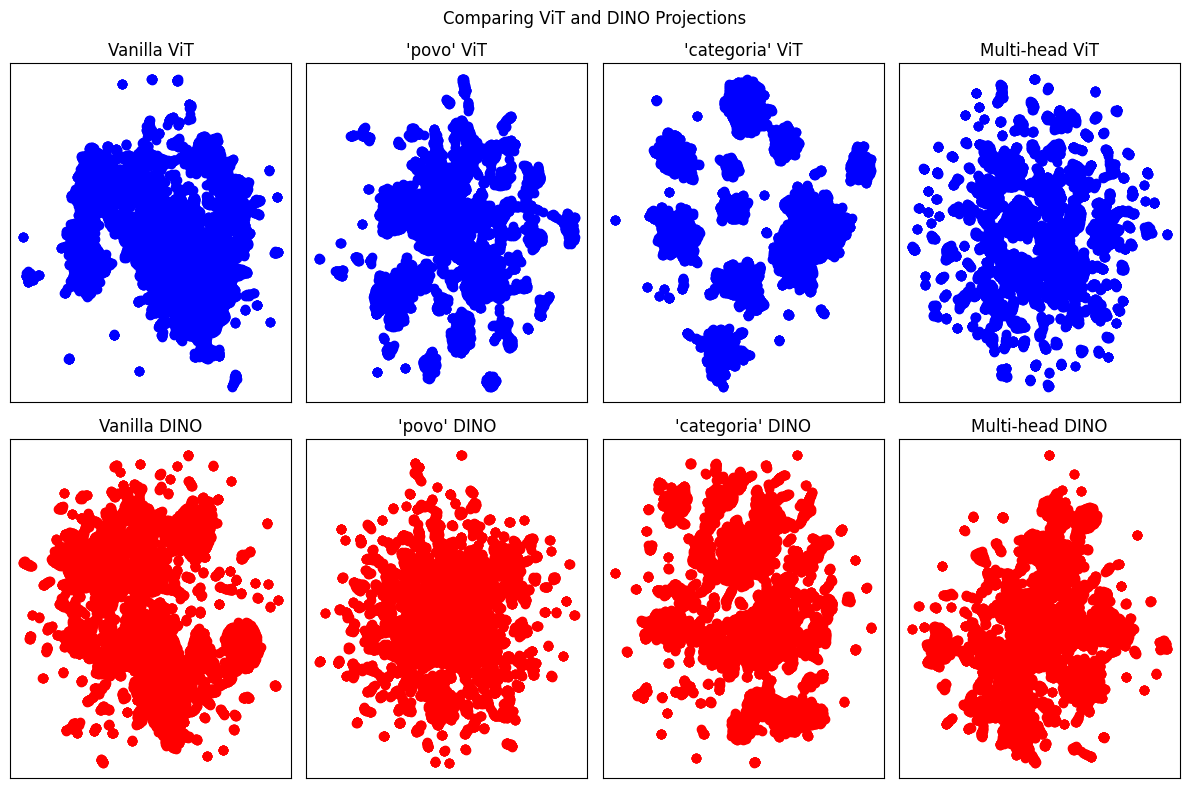

In [48]:
# Visualizing resulting projections
plt.figure(figsize=(12,8))
plt.suptitle('Comparing ViT and DINO Projections')

# Plotting all ViT projections
projs = [vanilla_vit_umap, povo_vit_umap, categoria_vit_umap, multihead_vit_umap]
proj_names = ["Vanilla ViT", "'povo' ViT", "'categoria' ViT", "Multi-head ViT"]
row_scatter_plot(projs, proj_names, 1, 'b', 2, 4)

# Plotting all DINO projections
projs = [vanilla_dino_umap, povo_dino_umap, categoria_dino_umap, multihead_dino_umap]
proj_names = ["Vanilla DINO", "'povo' DINO", "'categoria' DINO", "Multi-head DINO"]
row_scatter_plot(projs, proj_names, 2, 'r', 2, 4)

plt.tight_layout()
plt.show()

### Visualizing Clusters

/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:818: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


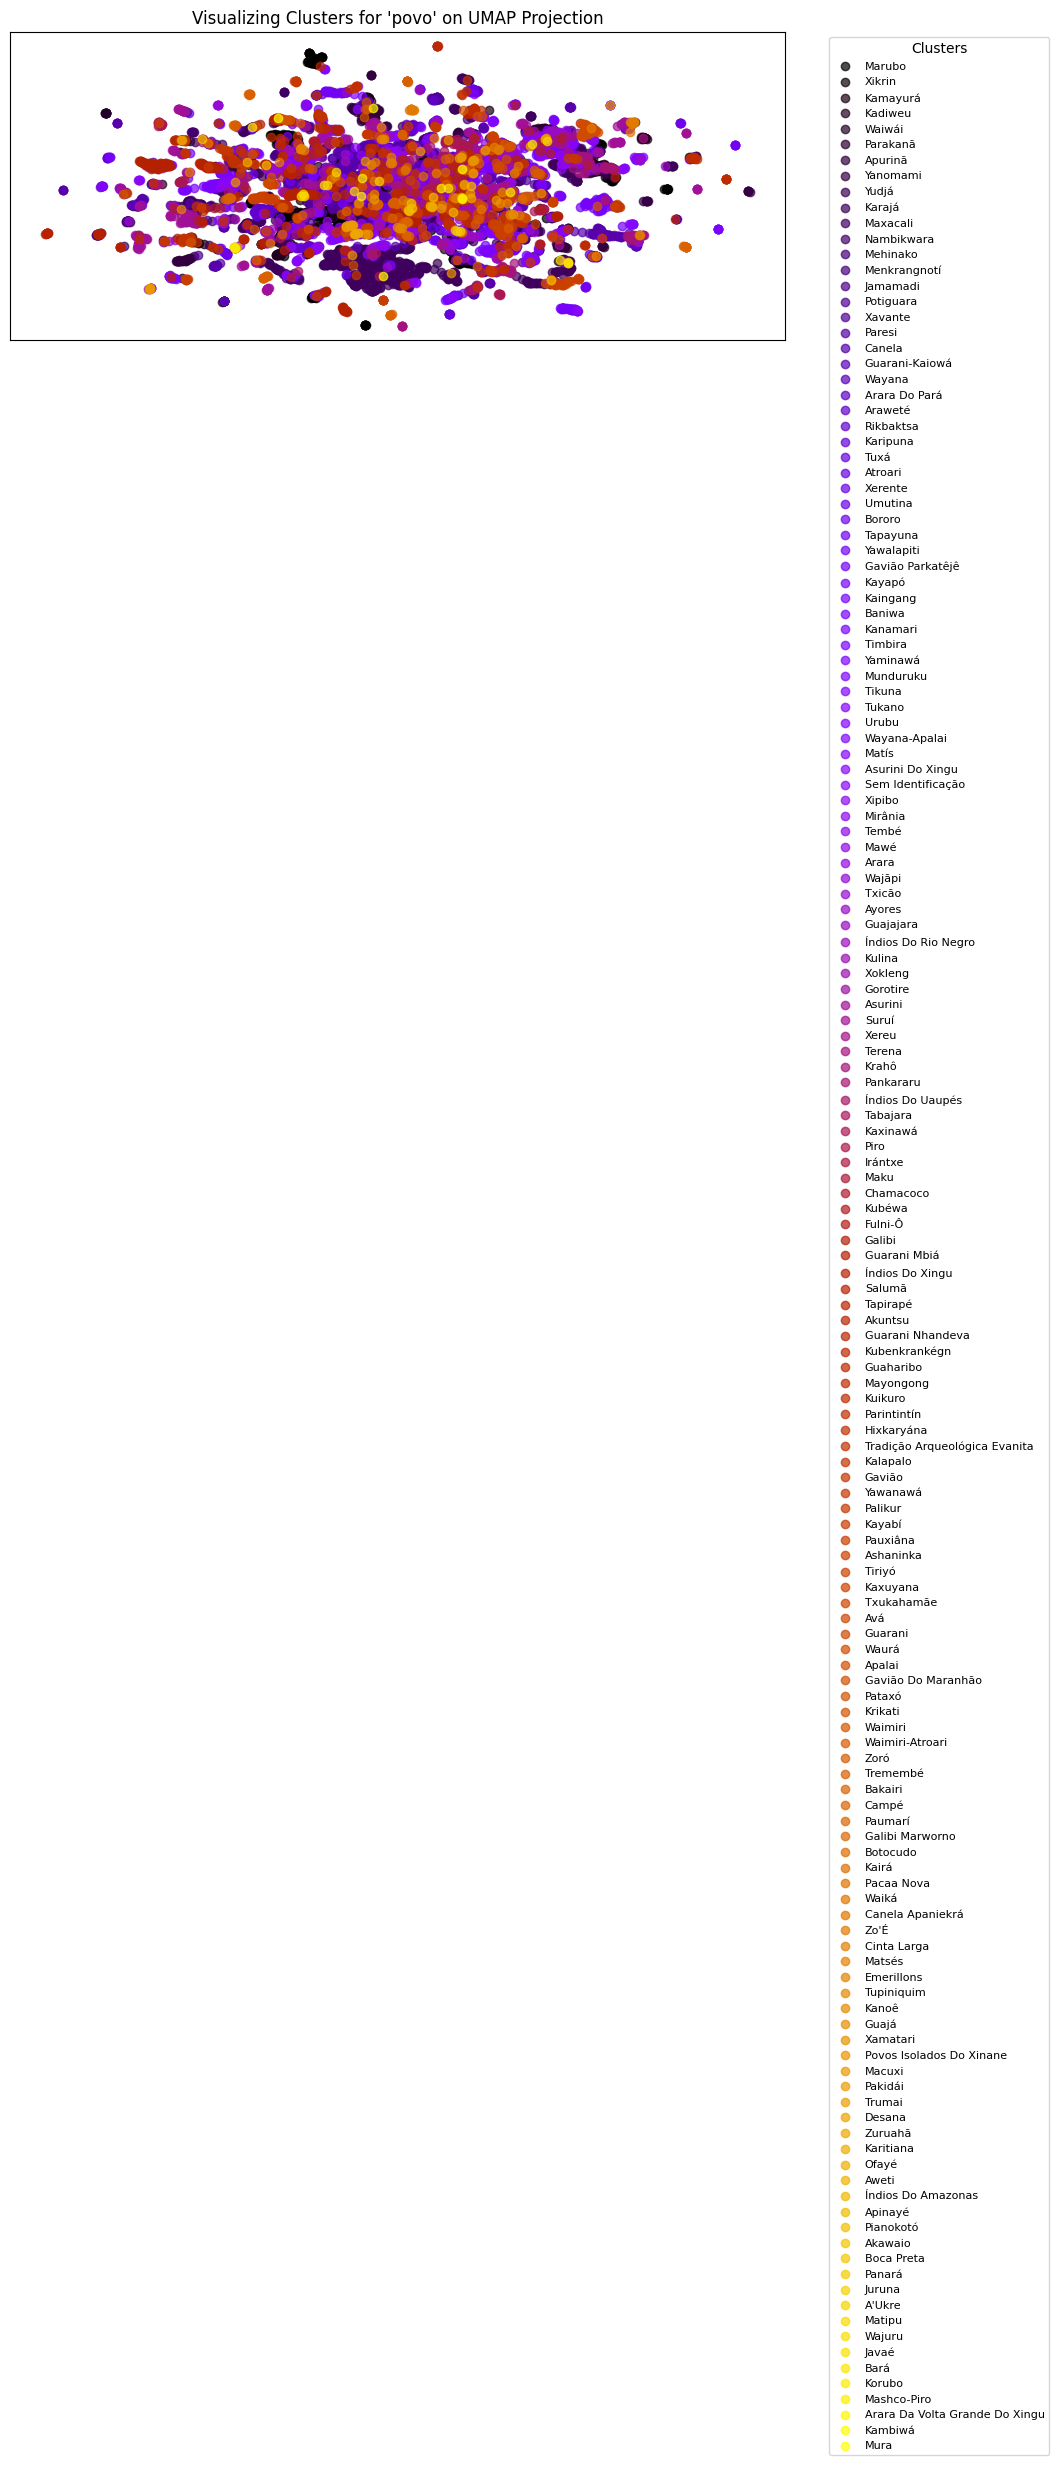

In [49]:
# Filtering dataframe to get only the part that contains images
filtered_df = ind_df.loc[ind_df['image_path'].notna()]

# Visualizing 'povo' cluster
visualizing_clusters(filtered_df, povo_dino_umap, povo_image_indices, 'povo', 'UMAP')

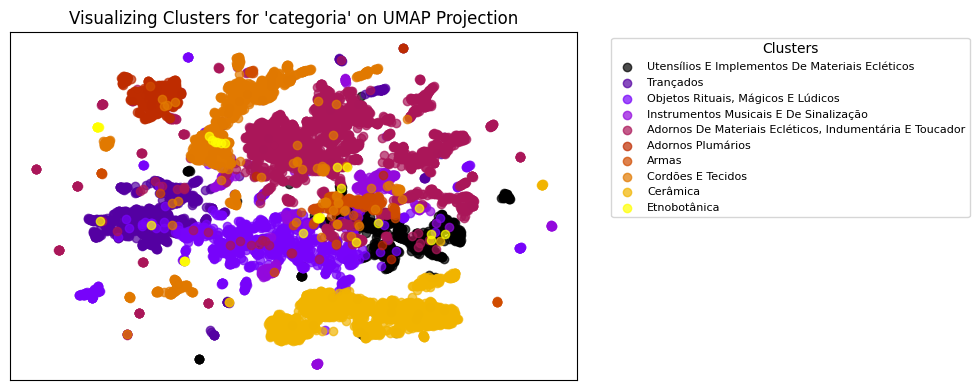

In [50]:
# Visualizing 'categoria' cluster
visualizing_clusters(filtered_df, categoria_dino_umap, categoria_image_indices, \
                     'categoria', 'UMAP')

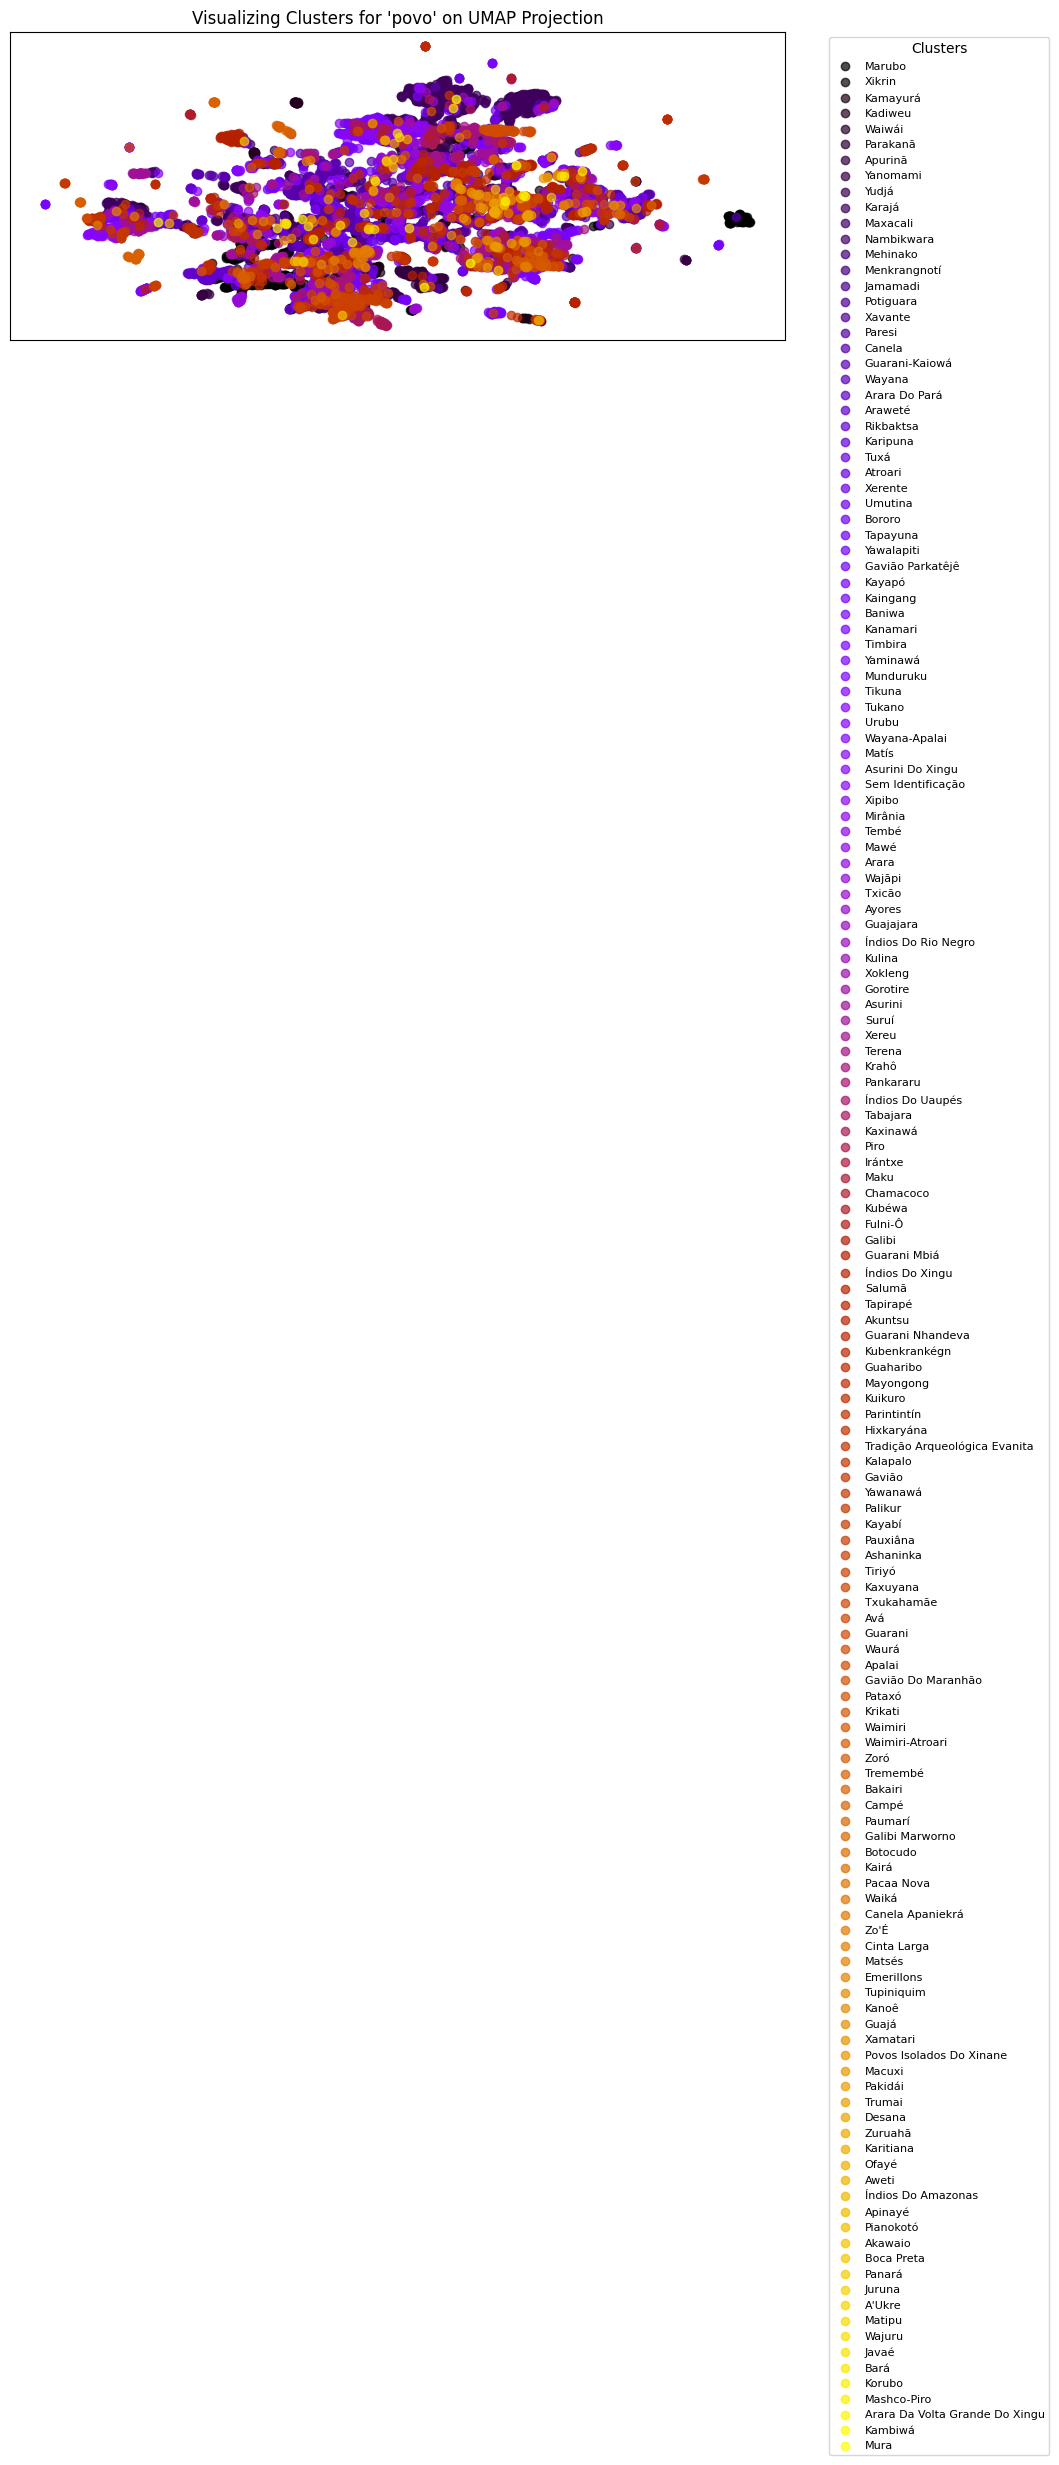

In [51]:
# Visualizing 'povo' cluster for multi-head modedl
visualizing_clusters(filtered_df, multihead_dino_umap, multihead_image_indices, \
                     'povo', 'UMAP')

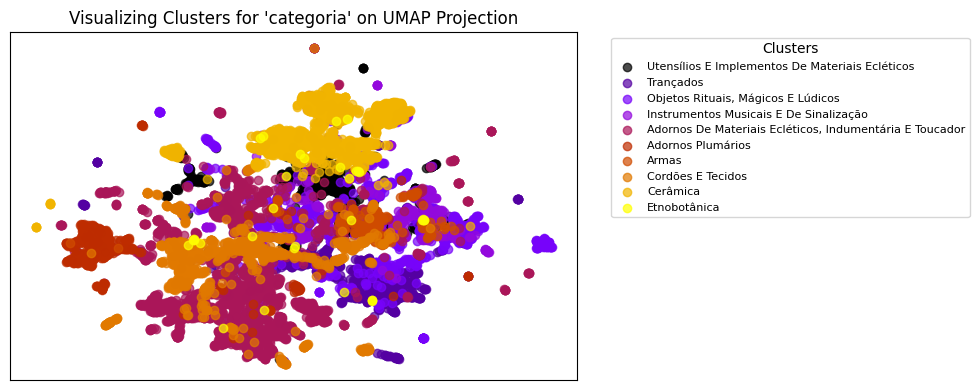

In [52]:
# Visualizing 'categoria' cluster for multi-head modedl
visualizing_clusters(filtered_df, multihead_dino_umap, multihead_image_indices, \
                     'categoria', 'UMAP')

In [53]:
# Saving outputs for visualization tool
_ = saving_outputs(filtered_df, povo_labels, vanilla_dino_umap, vanilla_image_indices, \
                   save_file='vanilla_dino.csv', no_clusters=True)

_ = saving_outputs(filtered_df, povo_labels, povo_dino_umap, povo_image_indices, 'povo', \
                   'povo_dino.csv')

_ = saving_outputs(filtered_df, categoria_labels, categoria_dino_umap, \
                   categoria_image_indices, 'categoria', 'categoria_dino.csv')

_ = saving_outputs(filtered_df, povo_labels, multihead_dino_umap, \
                   multihead_image_indices, save_file='multihead_dino.csv', no_clusters=True)